
# DEEP EUTECTIC SOLVENTS VISCOSITY. Data preparation and EDA


# 1. Reading data

In [18]:
# Importing the necessary libraries
!pip install git+https://github.com/samoturk/mol2vec --user
!pip install pubchempy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import re
import pubchempy as pcp
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Descriptors3D
from rdkit.Chem import rdchem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.rdchem import PeriodicTable, GetPeriodicTable
from rdkit.Chem import Fragments
from rdkit.Chem.rdchem import EditableMol
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import PyMol
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec


  Cloning https://github.com/samoturk/mol2vec to c:\users\lera-\appdata\local\temp\pip-req-build-pwe7lxp3
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec 'C:\Users\lera-\AppData\Local\Temp\pip-req-build-pwe7lxp3'


In [19]:
#Reading data
viscosity_df = pd.read_excel('DES database.xlsx', sheet_name = 'Viscosity')
viscosity_df = viscosity_df.round({'X#1 (molar fraction)': 3, 'X#2 (molar fraction)': 3, 'X#3 (molar fraction)': 3}) # Округление мольных долей

viscosity_df["Viscosity, cP"] = pd.to_numeric(viscosity_df["Viscosity, cP"])

viscosity_df.head(5)

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Viscosity, cP",Reference (DOI)
0,2,Ⅰ,1,0,0,0,0,Zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,0.500,0.500,NaN,298.15,3428.2,10.1016/j.jobe.2021.103056
1,2,Ⅰ,1,0,0,0,0,Zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,0.667,0.333,NaN,298.15,6153.7,10.1016/j.jobe.2021.103056
2,2,Ⅰ,1,0,0,0,0,Zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,0.333,0.667,NaN,298.15,3157.2,10.1016/j.jobe.2021.103056
3,2,Ⅰ,1,0,0,0,0,FeCl3,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,298.00,1640.0,10.1016/j.cep.2015.04.001
4,2,Ⅰ,1,0,0,0,0,FeCl3,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,303.00,1697.0,10.1016/j.cep.2015.04.001


**A database containing 4457 rows was collected**

In [20]:
viscosity_df.info() #Table Information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4457 entries, 0 to 4456
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Number of components  4457 non-null   int64  
 1   Type of DES           3473 non-null   object 
 2   I                     4457 non-null   int64  
 3   II                    4457 non-null   int64  
 4   III                   4457 non-null   int64  
 5   IV                    4457 non-null   int64  
 6   V                     4457 non-null   int64  
 7   Component#1           4457 non-null   object 
 8   Component#2           4457 non-null   object 
 9   Component#3           969 non-null    object 
 10  X#1 (molar fraction)  4457 non-null   float64
 11  X#2 (molar fraction)  4457 non-null   float64
 12  X#3 (molar fraction)  1051 non-null   float64
 13  Temperature, K        4457 non-null   float64
 14  Viscosity, cP         4457 non-null   float64
 15  Reference (DOI)      

In [21]:
viscosity_df.describe() #Main characteristics of numeric columns

,Number of components,I,II,III,IV,V,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Viscosity, cP"
count,4457.000000,4457.000000,4457.0,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,1051.000000,4457.000000,4457.000000
mean,2.220776,0.012565,0.0,0.598385,0.063720,0.494503,0.342755,0.576093,0.344188,318.045544,720.648948
std,0.414817,0.111398,0.0,0.490280,0.244281,0.500026,0.202677,0.233331,0.300332,19.707202,13068.438345
min,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.006000,0.012000,0.000000,278.150000,0.004000
25%,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.188000,0.400000,0.048000,303.150000,11.350000
50%,2.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.333000,0.656000,0.333000,313.150000,27.820000
75%,2.000000,0.000000,0.0,1.000000,0.000000,1.000000,0.500000,0.750000,0.583000,333.150000,95.287000
max,3.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.917000,0.950000,0.982000,373.150000,834114.000000


# 2. Converting substance names to SMILES
For further work with descriptors, it is necessary to translate the names of all chemical compounds into SMILES

## 2.1. Creating a table with unique substances

In [22]:
#Creating a table with unique substances
individual_compounds_df = pd.unique(viscosity_df[['Component#1', 'Component#2', 'Component#3']].values.ravel()) #List of unique substances
individual_compounds_df = pd.DataFrame(individual_compounds_df) #Transfer to dataframe
individual_compounds_df.columns = ['Compound'] # Renaming a column
individual_compounds_df = individual_compounds_df.dropna() #Deleting lines with NaN
individual_compounds_df.head() 

,Compound
0,Zinc chloride
1,1-Butyl-3-methylimidazolium chloride
3,FeCl3
4,Tetrabutylphosphonium bromide
5,AlCl3


In [23]:
for i in individual_compounds_df['Compound']:
    try: 
        #print(i)
        pcp.get_properties('CanonicalSMILES',i,'name')[0]['CanonicalSMILES']
    except IndexError:
        print(i)

In [24]:
# Function for getting CanonicalSMILES from pcp
f_canon_smiles = lambda x: pcp.get_properties('CanonicalSMILES', x, 'name')[0]['CanonicalSMILES'] if isinstance(x, str) else None
# Adding a new column using a previously written function
individual_compounds_df['CanonicalSMILES'] = individual_compounds_df['Compound'].apply(f_canon_smiles)

In [25]:
# Function for getting IsomericSMILES from pcp
f_isomeric_smiles = lambda x: pcp.get_properties('IsomericSMILES', x, 'name')[0]['IsomericSMILES'] if isinstance(x, str) else None
# Adding a new column using a previously written function
individual_compounds_df['IsomericSMILES'] = individual_compounds_df['Compound'].apply(f_isomeric_smiles)

In [26]:
#We select the Compound column as indexes
individual_compounds_df.index = individual_compounds_df['Compound']
individual_compounds_df.head(5)

,Compound,CanonicalSMILES,IsomericSMILES
Compound,,,
Zinc chloride,Zinc chloride,Cl[Zn]Cl,Cl[Zn]Cl
1-Butyl-3-methylimidazolium chloride,1-Butyl-3-methylimidazolium chloride,CCCCN1C=C[N+](=C1)C.[Cl-],CCCCN1C=C[N+](=C1)C.[Cl-]
FeCl3,FeCl3,Cl[Fe](Cl)Cl,Cl[Fe](Cl)Cl
Tetrabutylphosphonium bromide,Tetrabutylphosphonium bromide,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],CCCC[P+](CCCC)(CCCC)CCCC.[Br-]
AlCl3,AlCl3,[Al](Cl)(Cl)Cl,[Al](Cl)(Cl)Cl


In [27]:
# For isomers CanonicalSMILES and IsomericSMILES do not match
individual_compounds_df['isomer'] = individual_compounds_df['CanonicalSMILES'] != individual_compounds_df['IsomericSMILES']
print(individual_compounds_df['isomer'].sum()) #Output the number of isomers

47


In [28]:
#Writing to a file
individual_compounds_df.to_excel('individual_compounds_smiles.xlsx')

## 2.2. Adding data to the main table

In [29]:
# Function for adding IsomericSMILES to the main table by sample names
f_get_smiles = lambda x: individual_compounds_df.loc[x]['IsomericSMILES'] if isinstance(x, str) else None

viscosity_df['isomer_smiles#1'] = viscosity_df['Component#1'].apply(f_get_smiles) #Применение функции к таблице
viscosity_df['isomer_smiles#2'] = viscosity_df['Component#2'].apply(f_get_smiles)
viscosity_df['isomer_smiles#3'] = viscosity_df['Component#3'].apply(f_get_smiles)

viscosity_df

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Viscosity, cP",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
0,2,Ⅰ,1,0,0,0,0,Zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,0.500,0.500,NaN,298.15,3428.2000,10.1016/j.jobe.2021.103056,Cl[Zn]Cl,CCCCN1C=C[N+](=C1)C.[Cl-],None
1,2,Ⅰ,1,0,0,0,0,Zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,0.667,0.333,NaN,298.15,6153.7000,10.1016/j.jobe.2021.103056,Cl[Zn]Cl,CCCCN1C=C[N+](=C1)C.[Cl-],None
2,2,Ⅰ,1,0,0,0,0,Zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,0.333,0.667,NaN,298.15,3157.2000,10.1016/j.jobe.2021.103056,Cl[Zn]Cl,CCCCN1C=C[N+](=C1)C.[Cl-],None
3,2,Ⅰ,1,0,0,0,0,FeCl3,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,298.00,1640.0000,10.1016/j.cep.2015.04.001,Cl[Fe](Cl)Cl,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],None
4,2,Ⅰ,1,0,0,0,0,FeCl3,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,303.00,1697.0000,10.1016/j.cep.2015.04.001,Cl[Fe](Cl)Cl,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4452,3,NaN,0,0,1,0,1,Choline chloride,Glycerol,H2O,0.048,0.095,0.857,363.15,1.0262,10.1016/j.fluid.2014.01.028,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,O
4453,3,NaN,0,0,1,0,1,Choline chloride,Glycerol,H2O,0.033,0.066,0.901,363.15,0.7702,10.1016/j.fluid.2014.01.028,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,O
4454,3,NaN,0,0,1,0,1,Choline chloride,Glycerol,H2O,0.022,0.044,0.934,363.15,0.6145,10.1016/j.fluid.2014.01.028,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,O
4455,3,NaN,0,0,1,0,1,Choline chloride,Glycerol,H2O,0.013,0.027,0.960,363.15,0.4654,10.1016/j.fluid.2014.01.028,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,O


In [30]:
#Writing to a file
viscosity_df.to_csv('viscosity_with_smiles.csv')

## 2.3. Replacing names
Since many authors use different names (IUPAC, trivial), data analysis may be incorrect, so we will correct the names to the same ones by selecting the first synonym in the list

In [31]:
#Function for getting synonyms
def f_get_name(x):
  if isinstance(x, str):
    new_name = pcp.get_synonyms(x, 'name')[0]['Synonym'][0] #Choosing the first synonym
    if re.search('\d{2,}', new_name) is not None: #If the synonym is represented as a numeric code, select the following
      new_name = pcp.get_synonyms(x, 'name')[0]['Synonym'][1]
  return new_name

In [32]:
# Application of the function for a table with individual components
individual_compounds_df['Univers_name'] = individual_compounds_df['Compound'].apply(f_get_name)
individual_compounds_df

,Compound,CanonicalSMILES,IsomericSMILES,isomer,Univers_name
Compound,,,,,
Zinc chloride,Zinc chloride,Cl[Zn]Cl,Cl[Zn]Cl,False,zinc chloride
1-Butyl-3-methylimidazolium chloride,1-Butyl-3-methylimidazolium chloride,CCCCN1C=C[N+](=C1)C.[Cl-],CCCCN1C=C[N+](=C1)C.[Cl-],False,1-Butyl-3-methylimidazolium chloride
FeCl3,FeCl3,Cl[Fe](Cl)Cl,Cl[Fe](Cl)Cl,False,FERRIC CHLORIDE
Tetrabutylphosphonium bromide,Tetrabutylphosphonium bromide,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],CCCC[P+](CCCC)(CCCC)CCCC.[Br-],False,Tetrabutylphosphonium bromide
AlCl3,AlCl3,[Al](Cl)(Cl)Cl,[Al](Cl)(Cl)Cl,False,ALUMINUM CHLORIDE
...,...,...,...,...,...
"1,8-Octanediol","1,8-Octanediol",C(CCCCO)CCCO,C(CCCCO)CCCO,False,"1,8-Octanediol"
2-Ethylhexylamine,2-Ethylhexylamine,CCCCC(CC)CN,CCCCC(CC)CN,False,2-ETHYLHEXYLAMINE
Octylamine,Octylamine,CCCCCCCCN,CCCCCCCCN,False,Octylamine


In [33]:
#Writing to a file
individual_compounds_df.to_excel('individual_compounds_df_new_names.xlsx')

## 2.4. Adding data to the main table

In [34]:
#Reading required files
individual_compounds_df = pd.read_excel('individual_compounds_df_new_names.xlsx')
#We use the Compound column as the index
individual_compounds_df.index = individual_compounds_df['Compound']

In [35]:
# Function for adding identical names to the main table by sample names
f_get_smiles = lambda x: individual_compounds_df.loc[x]['Univers_name'] if isinstance(x, str) else None

viscosity_df['Component#1'] = viscosity_df['Component#1'].apply(f_get_smiles) #Applying the function to different columns
viscosity_df['Component#2'] = viscosity_df['Component#2'].apply(f_get_smiles)
viscosity_df['Component#3'] = viscosity_df['Component#3'].apply(f_get_smiles)

viscosity_df

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Viscosity, cP",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
0,2,Ⅰ,1,0,0,0,0,zinc chloride,1-Butyl-3-methylimidazolium chloride,None,0.500,0.500,NaN,298.15,3428.2000,10.1016/j.jobe.2021.103056,Cl[Zn]Cl,CCCCN1C=C[N+](=C1)C.[Cl-],None
1,2,Ⅰ,1,0,0,0,0,zinc chloride,1-Butyl-3-methylimidazolium chloride,None,0.667,0.333,NaN,298.15,6153.7000,10.1016/j.jobe.2021.103056,Cl[Zn]Cl,CCCCN1C=C[N+](=C1)C.[Cl-],None
2,2,Ⅰ,1,0,0,0,0,zinc chloride,1-Butyl-3-methylimidazolium chloride,None,0.333,0.667,NaN,298.15,3157.2000,10.1016/j.jobe.2021.103056,Cl[Zn]Cl,CCCCN1C=C[N+](=C1)C.[Cl-],None
3,2,Ⅰ,1,0,0,0,0,FERRIC CHLORIDE,Tetrabutylphosphonium bromide,None,0.333,0.667,NaN,298.00,1640.0000,10.1016/j.cep.2015.04.001,Cl[Fe](Cl)Cl,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],None
4,2,Ⅰ,1,0,0,0,0,FERRIC CHLORIDE,Tetrabutylphosphonium bromide,None,0.333,0.667,NaN,303.00,1697.0000,10.1016/j.cep.2015.04.001,Cl[Fe](Cl)Cl,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4452,3,NaN,0,0,1,0,1,CHOLINE CHLORIDE,glycerol,water,0.048,0.095,0.857,363.15,1.0262,10.1016/j.fluid.2014.01.028,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,O
4453,3,NaN,0,0,1,0,1,CHOLINE CHLORIDE,glycerol,water,0.033,0.066,0.901,363.15,0.7702,10.1016/j.fluid.2014.01.028,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,O
4454,3,NaN,0,0,1,0,1,CHOLINE CHLORIDE,glycerol,water,0.022,0.044,0.934,363.15,0.6145,10.1016/j.fluid.2014.01.028,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,O
4455,3,NaN,0,0,1,0,1,CHOLINE CHLORIDE,glycerol,water,0.013,0.027,0.960,363.15,0.4654,10.1016/j.fluid.2014.01.028,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,O


In [36]:
#Writing to a file
viscosity_df.to_excel('viscosity_new_names.xlsx')

# 3. Repeats
Often the same systems are studied in different articles at the same temperatures and component ratios, we will find the number of such repetitions and leave only one value for each system

In [37]:
# Grouping and counting binary DES that are repeated
repeat_DES = viscosity_df[['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K', 'Viscosity, cP']][viscosity_df['Number of components'] == 2].groupby(['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K']).agg('count')
repeat_DES = repeat_DES[repeat_DES['Viscosity, cP'] != 1].sort_values('Viscosity, cP', ascending = False) #Сортировка по убванию строк с повторениями
repeat_DES

Viscosity, cP
Number of components Component#1                       Component#2        X#1 (molar fraction) X#2 (molar fraction) Temperature, K               
2                    CHOLINE CHLORIDE                  ETHYLENE GLYCOL    0.333                0.667                298.15                      5
                                                                          0.250                0.750                298.15                      4
                                                       1,4-BUTANEDIOL     0.200                0.800                303.15                      4
                     MENTHOL                           Decanoic acid      0.500                0.500                298.15                      3
                                                       octanoic acid      0.500                0.500                298.15                      3
...                                                                                                                                           ...
                     Allyltriphenylphosphonium bromide TRIETHYLENE GLYCOL 0.091                0.909                333.15                      2
                                                                                                                    338.15                      2
                                                                                                                    343.15                      2
                                                                          0.200                0.800                293.15                      2
                     lidocaine                         Decanoic acid      0.333                0.667                298.15                      2

[158 rows x 1 columns]

In [38]:
# Total number of repetitions
repeat_DES['Viscosity, cP'].sum()

333

Quite a lot of values are repeated, since such Choline chloride-Urea systems are very popular and are being studied by many scientists

In [39]:
# Grouping and counting of tertiary DES that are repeated
repeat_DES = viscosity_df[['Number of components', 'Component#1', 'Component#2','Component#3',
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 'X#3 (molar fraction)',
                                 'Temperature, K', 'Viscosity, cP']][viscosity_df['Number of components'] == 3].groupby(['Number of components', 'Component#1', 'Component#2', 'Component#3', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 'X#3 (molar fraction)',
                                 'Temperature, K']).agg('count')
repeat_DES = repeat_DES[repeat_DES['Viscosity, cP'] != 1].sort_values('Viscosity, cP', ascending = False) #Sort descending row with repetitions
repeat_DES

,,,,,,,,"Viscosity, cP"
Number of components,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K",


There are no tertiary repetitions

## 3.1. Number, average and standard deviation of repetitions
Replace the repeats with average ones in the case of a small std and manually process the values with a large std

In [40]:
viscosity_df.to_excel('log2.xlsx')
viscosity_df["Viscosity, cP"] = pd.to_numeric(viscosity_df["Viscosity, cP"])
repeat_DES = viscosity_df[['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K', 'Viscosity, cP']][viscosity_df['Number of components'] == 2].groupby(['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K']).agg(['count', 'mean', 'std'])
repeat_DES.columns = ['_'.join(col).rstrip('_') for col in repeat_DES.columns.values] #Названия для новых столбцов
repeat_DES = repeat_DES[repeat_DES['Viscosity, cP_count'] != 1].sort_values('Viscosity, cP_count', ascending = False) #Сортировка по убыванию
repeat_DES.to_excel('repeat_DES_10_03.xlsx')
viscosity_df.to_excel('viscosity_df_10_03.xlsx')
repeat_DES

Viscosity, cP_count  \
Number of components Component#1                       Component#2        X#1 (molar fraction) X#2 (molar fraction) Temperature, K                        
2                    CHOLINE CHLORIDE                  ETHYLENE GLYCOL    0.333                0.667                298.15                            5   
                                                                          0.250                0.750                298.15                            4   
                                                       1,4-BUTANEDIOL     0.200                0.800                303.15                            4   
                     MENTHOL                           Decanoic acid      0.500                0.500                298.15                            3   
                                                       octanoic acid      0.500                0.500                298.15                            3   
...                                                                                                                                                 ...   
                     Allyltriphenylphosphonium bromide TRIETHYLENE GLYCOL 0.091                0.909                333.15                            2   
                                                                                                                    338.15                            2   
                                                                                                                    343.15                            2   
                                                                          0.200                0.800                293.15                            2   
                     lidocaine                         Decanoic acid      0.333                0.667                298.15                            2   

                                                                                                                                    Viscosity, cP_mean  \
Number of components Component#1                       Component#2        X#1 (molar fraction) X#2 (molar fraction) Temperature, K                       
2                    CHOLINE CHLORIDE                  ETHYLENE GLYCOL    0.333                0.667                298.15                   33.552000   
                                                                          0.250                0.750                298.15                   25.555000   
                                                       1,4-BUTANEDIOL     0.200                0.800                303.15                   53.677500   
                     MENTHOL                           Decanoic acid      0.500                0.500                298.15                   16.703333   
                                                       octanoic acid      0.500                0.500                298.15                   13.006667   
...                                                                                                                                                ...   
                     Allyltriphenylphosphonium bromide TRIETHYLENE GLYCOL 0.091                0.909                333.15                   15.645000   
                                                                                                                    338.15                   13.287000   
                                                                                                                    343.15                   11.402000   
                                                                          0.200                0.800                293.15                  233.750000   
                     lidocaine                         Decanoic acid      0.333                0.667                298.15                  209.850000   

                                                                                                                 

## 3.2. Working with data where std/mean > 0.1

In [41]:
repeat_DES_less0_1 = repeat_DES[repeat_DES['Viscosity, cP_std']/repeat_DES['Viscosity, cP_mean'] >= 0.1] #Selecting values with std/mean > 0.1
repeat_DES_less0_1.reset_index(level = [0, 1, 2, 3, 4, 5], inplace = True) # Reset Indexes
repeat_DES_less0_1.to_excel('repeat_DES_less0_1.xlsx')
repeat_DES_less0_1

,Number of components,Component#1,Component#2,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K","Viscosity, cP_count","Viscosity, cP_mean","Viscosity, cP_std"
0,2,CHOLINE CHLORIDE,ETHYLENE GLYCOL,0.333,0.667,298.15,5,33.552000,9.948845
1,2,CHOLINE CHLORIDE,ETHYLENE GLYCOL,0.250,0.750,298.15,4,25.555000,4.981041
2,2,CHOLINE CHLORIDE,"1,4-BUTANEDIOL",0.200,0.800,303.15,4,53.677500,6.962473
3,2,MENTHOL,Decanoic acid,0.500,0.500,298.15,3,16.703333,3.481815
4,2,MENTHOL,octanoic acid,0.500,0.500,298.15,3,13.006667,2.670755
5,2,CHOLINE CHLORIDE,urea,0.333,0.667,303.15,3,553.000000,339.501105
6,2,CHOLINE CHLORIDE,malonic acid,0.500,0.500,303.15,3,671.966667,287.071251
7,2,CHOLINE CHLORIDE,malonic acid,0.500,0.500,293.15,3,1111.000000,820.116455
8,2,CHOLINE CHLORIDE,"1,4-BUTANEDIOL",0.200,0.800,293.15,3,82.896667,19.843438
9,2,MENTHOL,THYMOL,0.500,0.500,298.15,3,42.553333,15.201583


In [42]:
# calculate the average viscosity for each combination of components, molar fractions and temperature from repeat_DES_lys 0_1 and removes rows with viscosity deviating from the average by more than a certain threshold
for a in repeat_DES_less0_1['Component#1'].index:
    df1 = viscosity_df[(viscosity_df['Number of components'] == 2) &
           (viscosity_df['Component#1'] == repeat_DES_less0_1['Component#1'][a]) &
           (viscosity_df['Component#2'] == repeat_DES_less0_1['Component#2'][a]) &
           (viscosity_df['X#1 (molar fraction)'] == repeat_DES_less0_1['X#1 (molar fraction)'][a]) &
           (viscosity_df['X#2 (molar fraction)'] == repeat_DES_less0_1['X#2 (molar fraction)'][a]) &
           (viscosity_df['Temperature, K'] == repeat_DES_less0_1['Temperature, K'][a])]
    sum=0;
    count=0;
    df1["Viscosity, cP"] = pd.to_numeric(df1["Viscosity, cP"])
    for j in df1["Viscosity, cP"].index:
        sum=sum+df1["Viscosity, cP"][j]
        count+=1
    print(sum/count)
    mean = sum/count
    maxDelta=0
    maxDeltaIndex=-1
    for j in df1["Viscosity, cP"].index:
        delta=(df1["Viscosity, cP"][j]-mean)*(df1["Viscosity, cP"][j]-mean)
        if(delta>maxDelta):
            maxDelta=delta
            maxDeltaIndex=j
    if maxDelta>0 and count!=2:
        print('Delete'+str(j))
        viscosity_df = viscosity_df.drop(index = j)



33.552
Delete1625
25.555
Delete1632
53.6775
Delete1772
16.703333333333333
Delete2941
13.006666666666668
Delete2942
553.0
Delete1893
671.9666666666667
Delete1875
1111.0
Delete1874
82.89666666666666
Delete1767
42.553333333333335
Delete2940
141.75
723.0
30.0
601.5
490.0
338.45500000000004
159.75
7414.75
2144.85
453.3
385.0
426.5
211.8964
348.0
317.5
28.75
71.85
261.87
362.25
200.75
117.2
4521.0
636.05
209.5
163.5
37.55
123.65
595.605
34.4
31.375
37.575
66.0
69.0
66.5
209.85


C:\Users\lera-\AppData\Local\Temp\ipykernel_18024\2988340763.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Viscosity, cP"] = pd.to_numeric(df1["Viscosity, cP"])
C:\Users\lera-\AppData\Local\Temp\ipykernel_18024\2988340763.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Viscosity, cP"] = pd.to_numeric(df1["Viscosity, cP"])
C:\Users\lera-\AppData\Local\Temp\ipykernel_18024\2988340763.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

## 3.3. Replacement with average

In [43]:
# Updated repeat_DES
repeat_DES = viscosity_df[['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K', 'Viscosity, cP']][viscosity_df['Number of components'] == 2].groupby(['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K']).agg(['count', 'mean', 'std'])
repeat_DES.columns = ['_'.join(col).rstrip('_') for col in repeat_DES.columns.values] #Names for new columns
repeat_DES = repeat_DES[repeat_DES['Viscosity, cP_count'] != 1].sort_values('Viscosity, cP_count', ascending = False) #Sort in descending order
repeat_DES

Viscosity, cP_count  \
Number of components Component#1                       Component#2        X#1 (molar fraction) X#2 (molar fraction) Temperature, K                        
2                    CHOLINE CHLORIDE                  ETHYLENE GLYCOL    0.333                0.667                298.15                            4   
                     THYMOL                            Decanoic acid      0.500                0.500                298.15                            3   
                     CHOLINE CHLORIDE                  ETHYLENE GLYCOL    0.200                0.800                298.15                            3   
                                                                          0.250                0.750                298.15                            3   
                                                                          0.167                0.833                298.15                            3   
...                                                                                                                                                 ...   
                     Allyltriphenylphosphonium bromide TRIETHYLENE GLYCOL 0.091                0.909                338.15                            2   
                                                                                                                    343.15                            2   
                                                                          0.200                0.800                293.15                            2   
                                                                                                                    298.15                            2   
                     lidocaine                         Decanoic acid      0.333                0.667                298.15                            2   

                                                                                                                                    Viscosity, cP_mean  \
Number of components Component#1                       Component#2        X#1 (molar fraction) X#2 (molar fraction) Temperature, K                       
2                    CHOLINE CHLORIDE                  ETHYLENE GLYCOL    0.333                0.667                298.15                   31.640000   
                     THYMOL                            Decanoic acid      0.500                0.500                298.15                   11.720000   
                     CHOLINE CHLORIDE                  ETHYLENE GLYCOL    0.200                0.800                298.15                   25.303333   
                                                                          0.250                0.750                298.15                   25.373333   
                                                                          0.167                0.833                298.15                   22.453333   
...                                                                                                                                                ...   
                     Allyltriphenylphosphonium bromide TRIETHYLENE GLYCOL 0.091                0.909                338.15                   13.287000   
                                                                                                                    343.15                   11.402000   
                                                                          0.200                0.800                293.15                  233.750000   
                                                                                                                    298.15                  166.520000   
                     lidocaine                         Decanoic acid      0.333                0.667                298.15                  209.850000   

                                                                                                                 

Where the ratio std/mean is less than 0.1, the cells in the main table can be filled with average values and duplicate rows can be deleted

In [44]:
repeat_DES_less10percent = repeat_DES[repeat_DES['Viscosity, cP_std']/repeat_DES['Viscosity, cP_mean'] < 0.1] #Choose of values with std/mean < 0.1
repeat_DES_less10percent.reset_index(level = [0, 1, 2, 3, 4, 5], inplace = True) # Reset Indexes
repeat_DES_less10percent.to_excel('repeat_DES_less10percent.xlsx')
repeat_DES_less10percent

,Number of components,Component#1,Component#2,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K","Viscosity, cP_count","Viscosity, cP_mean","Viscosity, cP_std"
0,2,THYMOL,Decanoic acid,0.500,0.500,298.15,3,11.720000,0.484974
1,2,CHOLINE CHLORIDE,ETHYLENE GLYCOL,0.200,0.800,298.15,3,25.303333,0.799396
2,2,CHOLINE CHLORIDE,ETHYLENE GLYCOL,0.167,0.833,298.15,3,22.453333,0.785196
3,2,CHOLINE CHLORIDE,TRIETHYLENE GLYCOL,0.143,0.857,298.15,2,44.950000,0.070711
4,2,CHOLINE CHLORIDE,GLUTARIC ACID,0.500,0.500,298.15,2,2129.050000,161.291057
...,...,...,...,...,...,...,...,...,...
108,2,Allyltriphenylphosphonium bromide,TRIETHYLENE GLYCOL,0.091,0.909,333.15,2,15.645000,0.000000
109,2,Allyltriphenylphosphonium bromide,TRIETHYLENE GLYCOL,0.091,0.909,338.15,2,13.287000,0.000000
110,2,Allyltriphenylphosphonium bromide,TRIETHYLENE GLYCOL,0.091,0.909,343.15,2,11.402000,0.000000
111,2,Allyltriphenylphosphonium bromide,TRIETHYLENE GLYCOL,0.200,0.800,293.15,2,233.750000,0.000000


In [45]:
# Cycle to replace values with averages
print(viscosity_df['Number of components'][1])
print(repeat_DES_less10percent['Number of components'][1])
for i in viscosity_df.index:
  for j in repeat_DES_less10percent.index:
    if (viscosity_df['Number of components'][i] == repeat_DES_less10percent['Number of components'][j]) & (viscosity_df['Component#1'][i] == repeat_DES_less10percent['Component#1'][j]) & (viscosity_df['Component#2'][i] == repeat_DES_less10percent['Component#2'][j]) & (viscosity_df['X#1 (molar fraction)'][i] == repeat_DES_less10percent['X#1 (molar fraction)'][j]) & (viscosity_df['X#2 (molar fraction)'][i] == repeat_DES_less10percent['X#2 (molar fraction)'][j]) & (viscosity_df['Temperature, K'][i] == repeat_DES_less10percent['Temperature, K'][j]):

      viscosity_df['Viscosity, cP'][i] = repeat_DES_less10percent['Viscosity, cP_mean'][j]


2
2


C:\Users\lera-\AppData\Local\Temp\ipykernel_18024\2503074192.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viscosity_df['Viscosity, cP'][i] = repeat_DES_less10percent['Viscosity, cP_mean'][j]


In [46]:
repeat_DES

Viscosity, cP_count  \
Number of components Component#1                       Component#2        X#1 (molar fraction) X#2 (molar fraction) Temperature, K                        
2                    CHOLINE CHLORIDE                  ETHYLENE GLYCOL    0.333                0.667                298.15                            4   
                     THYMOL                            Decanoic acid      0.500                0.500                298.15                            3   
                     CHOLINE CHLORIDE                  ETHYLENE GLYCOL    0.200                0.800                298.15                            3   
                                                                          0.250                0.750                298.15                            3   
                                                                          0.167                0.833                298.15                            3   
...                                                                                                                                                 ...   
                     Allyltriphenylphosphonium bromide TRIETHYLENE GLYCOL 0.091                0.909                338.15                            2   
                                                                                                                    343.15                            2   
                                                                          0.200                0.800                293.15                            2   
                                                                                                                    298.15                            2   
                     lidocaine                         Decanoic acid      0.333                0.667                298.15                            2   

                                                                                                                                    Viscosity, cP_mean  \
Number of components Component#1                       Component#2        X#1 (molar fraction) X#2 (molar fraction) Temperature, K                       
2                    CHOLINE CHLORIDE                  ETHYLENE GLYCOL    0.333                0.667                298.15                   31.640000   
                     THYMOL                            Decanoic acid      0.500                0.500                298.15                   11.720000   
                     CHOLINE CHLORIDE                  ETHYLENE GLYCOL    0.200                0.800                298.15                   25.303333   
                                                                          0.250                0.750                298.15                   25.373333   
                                                                          0.167                0.833                298.15                   22.453333   
...                                                                                                                                                ...   
                     Allyltriphenylphosphonium bromide TRIETHYLENE GLYCOL 0.091                0.909                338.15                   13.287000   
                                                                                                                    343.15                   11.402000   
                                                                          0.200                0.800                293.15                  233.750000   
                                                                                                                    298.15                  166.520000   
                     lidocaine                         Decanoic acid      0.333                0.667                298.15                  209.850000   

                                                                                                                 

## 3.4. Removing duplicate rows

In [47]:
# Removing duplicate rows, leaving only the first occurrence, taking into account certain columns
viscosity_df = viscosity_df.drop_duplicates(keep='first', subset=['Number of components', 'Type of DES', 'Component#1', 'Component#2', 'X#1 (molar fraction)', 'X#2 (molar fraction)', 'Temperature, K'])

## 3.5. Checking for the absence of repetitions

In [48]:
# Grouping and counting binary DES that are repeated
repeat_DES = viscosity_df[['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K', 'Viscosity, cP']][viscosity_df['Number of components'] == 2].groupby(['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K']).agg('count')
repeat_DES = repeat_DES[repeat_DES['Viscosity, cP'] != 1].sort_values('Viscosity, cP', ascending = False) #Сортировка по убванию строк с повторениями
repeat_DES

,,,,,,"Viscosity, cP"
Number of components,Component#1,Component#2,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K",


In [49]:
viscosity_df.to_excel('viscosity_without_rep.xlsx')

# 4. Data analysis
To understand what data is presented in the database, we will conduct a preliminary data analysis

## 4.1. Amount of data
At the first stage, we will consider the amount of data of different types presented in the database

In [50]:
# Reading the file
plt.style.use('seaborn')
viscosity_df = pd.read_excel('viscosity_without_rep.xlsx')
viscosity_df["Viscosity, cP"] = pd.to_numeric(viscosity_df["Viscosity, cP"])
viscosity_df = viscosity_df.drop(np.where(viscosity_df['Viscosity, cP'] > 2000)[0])
# Replacing with the correct DES type value
viscosity_df['Type of DES'] = viscosity_df['Type of DES'].replace(np.nan, '3')
viscosity_df

,Unnamed: 0,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Viscosity, cP",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
3,3,2,Ⅰ,1,0,0,0,0,FERRIC CHLORIDE,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,298.00,1640.0000,10.1016/j.cep.2015.04.001,Cl[Fe](Cl)Cl,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],NaN
4,4,2,Ⅰ,1,0,0,0,0,FERRIC CHLORIDE,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,303.00,1697.0000,10.1016/j.cep.2015.04.001,Cl[Fe](Cl)Cl,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],NaN
5,5,2,Ⅰ,1,0,0,0,0,FERRIC CHLORIDE,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,313.00,1279.0000,10.1016/j.cep.2015.04.001,Cl[Fe](Cl)Cl,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],NaN
6,6,2,Ⅰ,1,0,0,0,0,FERRIC CHLORIDE,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,323.00,826.0000,10.1016/j.cep.2015.04.001,Cl[Fe](Cl)Cl,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],NaN
7,7,2,Ⅰ,1,0,0,0,0,FERRIC CHLORIDE,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,333.00,407.0000,10.1016/j.cep.2015.04.001,Cl[Fe](Cl)Cl,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4251,4452,3,3,0,0,1,0,1,CHOLINE CHLORIDE,glycerol,water,0.048,0.095,0.857,363.15,1.0262,10.1016/j.fluid.2014.01.028,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,O
4252,4453,3,3,0,0,1,0,1,CHOLINE CHLORIDE,glycerol,water,0.033,0.066,0.901,363.15,0.7702,10.1016/j.fluid.2014.01.028,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,O
4253,4454,3,3,0,0,1,0,1,CHOLINE CHLORIDE,glycerol,water,0.022,0.044,0.934,363.15,0.6145,10.1016/j.fluid.2014.01.028,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,O
4254,4455,3,3,0,0,1,0,1,CHOLINE CHLORIDE,glycerol,water,0.013,0.027,0.960,363.15,0.4654,10.1016/j.fluid.2014.01.028,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,O


### 4.1.1. The ratio of binary and tertiary systems
Let's build a pie chart to find out the ratio of binary and tertiary systems

In [51]:
# Grouping by the number of system components
bin_ter = viscosity_df[['Number of components', 'Type of DES', 'Viscosity, cP']].groupby(['Number of components', 'Type of DES']).agg('count') 
bin_ter

Viscosity, cP
Number of components Type of DES               
2                    Ⅰ                       15
                     Ⅲ                     1724
                     Ⅳ                      124
                     Ⅴ                     1332
3                    3                      897

In [52]:
viscosity_df[(viscosity_df['Type of DES'] == 3) & (viscosity_df['Number of components'] == 2)]

,Unnamed: 0,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Viscosity, cP",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3


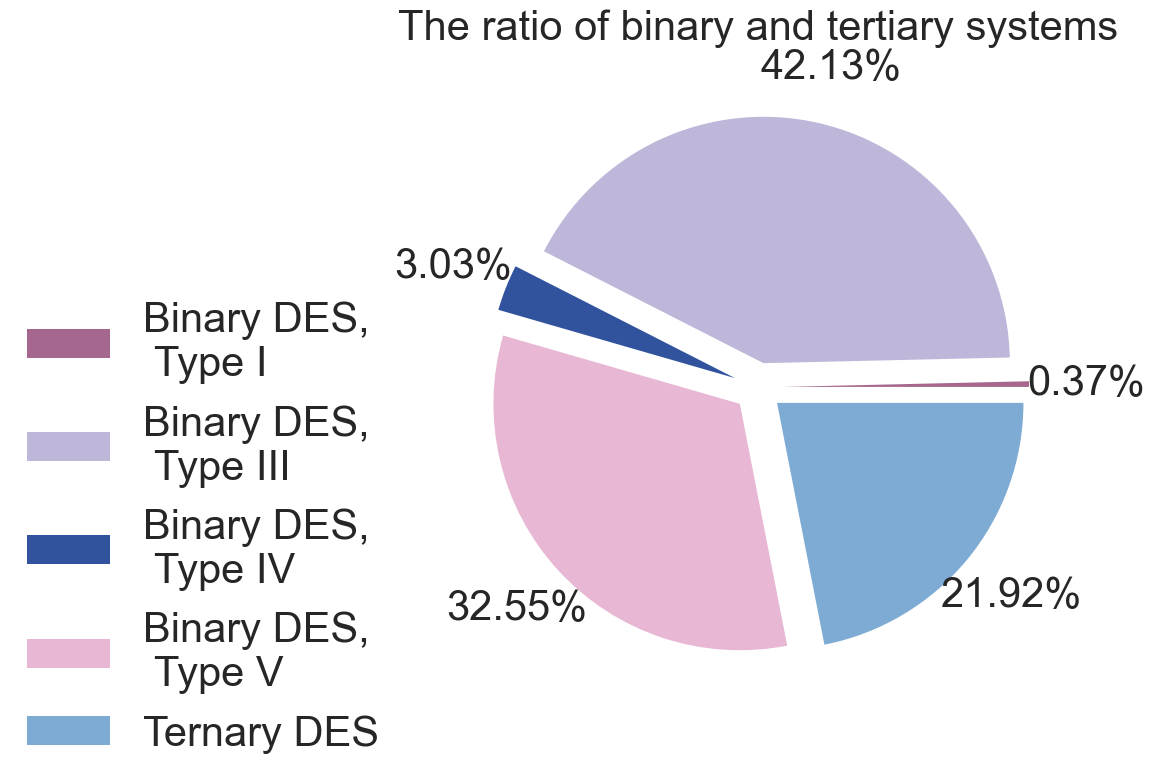

In [53]:
colors = ['#a5678e', '#beb7d9', '#31539d','#e8b7d4', '#7eabd4'] # Palette of colors
fig, ax = plt.subplots(figsize = (12, 8)) #Initialization - creating an empty graph
labels = ['Binary DES,\n Type I', 'Binary DES, \n Type III', 'Binary DES, \n Type IV', 'Binary DES,\n Type V', 'Ternary DES']
ax.pie(bin_ter['Viscosity, cP'], colors = colors, autopct = '%1.2f%%', textprops={'fontsize': 30}, explode=[0.1, 0.1, 0.1, 0.1, 0.1], pctdistance=1.23, radius=1) #Change names, colors, add%, increase font
plt.legend(
    bbox_to_anchor = (-0.3, 0.45, 0.25, 0.25),
    loc = 'best', labels = labels, fontsize = 30)
ax.set_title('The ratio of binary and tertiary systems', fontsize = 30, y=1.05) #Title of a separate chart
plt.show() #Graph demonstration

It can be seen that most systems are binary, this is explained by a small number of articles about tertiary DES.

### 4.1.2. The ratio of different types of DES for binary systems

In [54]:
# Grouping binary systems by type
types_bin = viscosity_df[['Type of DES', 'Number of components']][viscosity_df['Number of components'] == 2].groupby('Type of DES').agg('count') 
types_bin

,Number of components
Type of DES,
Ⅰ,15
Ⅲ,1724
Ⅳ,124
Ⅴ,1332


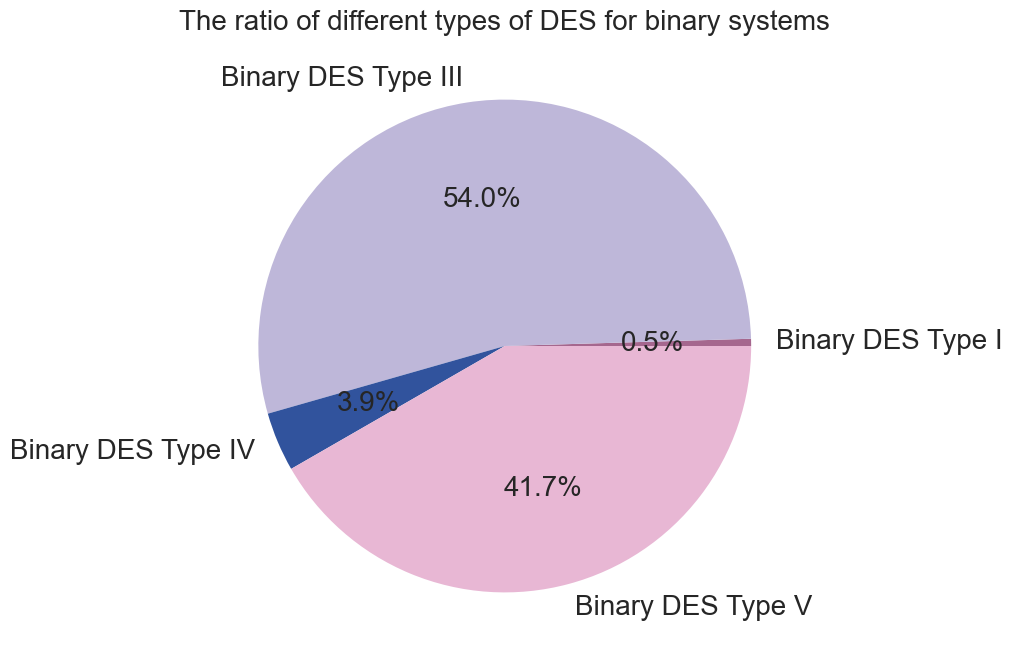

In [55]:
fig, ax = plt.subplots(figsize = (12, 8)) #Initialization - creating an empty graph
ax.pie(types_bin['Number of components'], labels = ['Binary DES Type I', 'Binary DES Type III', 'Binary DES Type IV', 'Binary DES Type V'], colors = colors, autopct = '%1.1f%%', textprops={'fontsize': 20}) #Change names, colors, add%, increase font
ax.set_title('The ratio of different types of DES for binary systems', fontsize = 20) #Title of a separate chart
plt.show() #Graph demonstration

Most systems belong to type III and V, as they are more often studied by scientists. There are no type II systems, since due to the fact that they consist of hydrate and ammonium salt, it is more correct to add them to tertiary systems, where the third component will be water

### 4.1.3. The most popular components of binary systems


#### 4.1.3.1. The most popular acceptor

In [56]:
#Table for the number of unique systems in various articles
max_comp = viscosity_df[viscosity_df['Number of components'] == 2][['Component#1','Component#2', 'Reference (DOI)']].groupby(['Component#1','Component#2']).agg('nunique')
max_comp = max_comp.sort_values('Reference (DOI)', ascending = False)
#To understand the number of times a particular acceptor participates in various systems, we reset the indexes and regroup the samples
max_comp.reset_index(level=[0,1], inplace = True)
#Regrouping
max_acceptor = max_comp[['Component#1', 'Reference (DOI)']].groupby('Component#1').agg('sum')
max_acceptor = max_acceptor.sort_values('Reference (DOI)', ascending = False)
max_acceptor['Component#1'] = max_acceptor.index
f_get_upper = lambda x: x.upper()
max_acceptor['Component#1'] = max_acceptor['Component#1'].apply(f_get_upper)
max_acceptor.index = max_acceptor['Component#1']
max_acceptor

,Reference (DOI),Component#1
Component#1,,
CHOLINE CHLORIDE,61,CHOLINE CHLORIDE
ETHYLAMINE HYDROCHLORIDE,26,ETHYLAMINE HYDROCHLORIDE
THYMOL,24,THYMOL
MENTHOL,23,MENTHOL
L-MENTHOL,17,L-MENTHOL
...,...,...
4-METHYLMORPHOLINE N-OXIDE,1,4-METHYLMORPHOLINE N-OXIDE
4-HYDROXYPYRIDINE,1,4-HYDROXYPYRIDINE
3-HYDROXYPYRIDINE,1,3-HYDROXYPYRIDINE


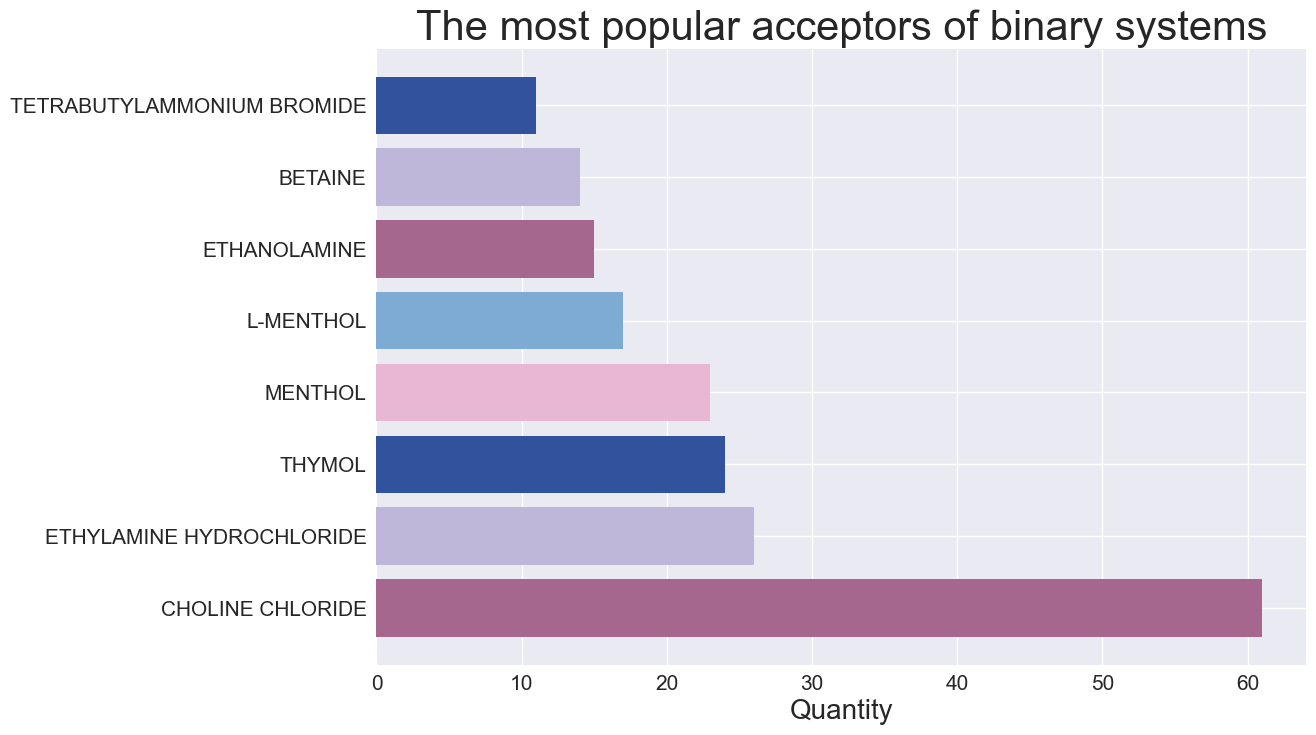

In [57]:
fig, ax = plt.subplots(figsize = (12, 8)) # Chart initialization
ax.barh(max_acceptor.head(8).index, max_acceptor.head(8)['Reference (DOI)'], color = colors) # Building a bar chart
ax.set_title('The most popular acceptors of binary systems', fontsize = 30) # Title
ax.set_xlabel('Quantity', fontsize = 20) # X-axis signature
ax.set_yticks(max_acceptor.index[0:8])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show() #Demonstration

The most popular acceptor is choline chloride, 61 entries correspond to it

#### 4.1.3.2. The most popular donor

In [58]:
#To understand the number of times a particular donor participates in various systems, we reset the indexes and regroup the samples
max_donor = max_comp[['Component#2', 'Reference (DOI)']].groupby('Component#2').agg('sum')
max_donor = max_donor.sort_values('Reference (DOI)', ascending = False) #Sort in descending order
max_donor['Component#2'] = max_donor.index
f_get_upper = lambda x: x.upper()
max_donor['Component#2'] = max_donor['Component#2'].apply(f_get_upper)
max_donor.index = max_donor['Component#2']
max_donor
max_donor

,Reference (DOI),Component#2
Component#2,,
ETHYLENE GLYCOL,29,ETHYLENE GLYCOL
UREA,27,UREA
DECANOIC ACID,24,DECANOIC ACID
LAURIC ACID,17,LAURIC ACID
LEVULINIC ACID,15,LEVULINIC ACID
...,...,...
L-ALANINE,1,L-ALANINE
L-LACTIC ACID,1,L-LACTIC ACID
GLUTARIC ACID,1,GLUTARIC ACID


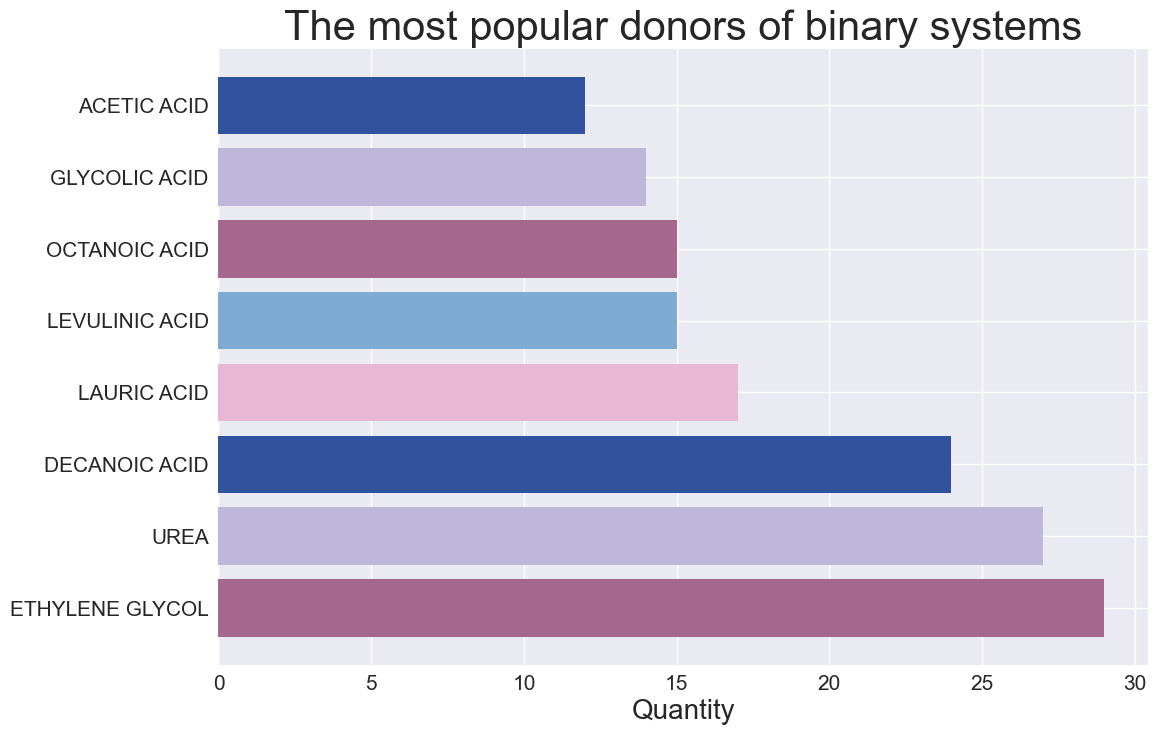

In [59]:
fig, ax = plt.subplots(figsize = (12, 8)) # Chart initialization
ax.barh(max_donor.head(8).index, max_donor.head(8)['Reference (DOI)'], color = colors) # Построение столбчатой диаграммы
ax.set_title('The most popular donors of binary systems', fontsize = 30) # Title
ax.set_xlabel('Quantity', fontsize = 20) # X-axis signature
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show() #Demonstration

The distribution of donors is more uniform, the most popular are Urea, Ethylene glycol, Decanoic acid, Lauric acid

#### 4.1.3.3. The most popular system


In [60]:
#Grouping by two components
popular_system = viscosity_df[viscosity_df['Number of components'] == 2][['Component#1', 'Component#2', 'Viscosity, cP']].groupby(['Component#1', 'Component#2']).agg('count')
popular_system = popular_system.sort_values('Viscosity, cP', ascending = False) #Sort in descending order
popular_system.head(50)

Viscosity, cP
Component#1                                      Component#2                                
CHOLINE CHLORIDE                                 4-methylphenol                          117
                                                 m-cresol                                117
                                                 o-cresol                                108
                                                 1,4-BUTANEDIOL                           92
l-Menthol                                        phenol                                   78
CHOLINE CHLORIDE                                 ETHYLENE GLYCOL                          78
                                                 glycerol                                 66
l-Menthol                                        CARVACROL                                60
CHOLINE CHLORIDE                                 phenol                                   60
                                                 1,3-PROPANEDIOL                          47
l-Menthol                                        octanoic acid                            44
                                                 THYMOL                                   41
CHOLINE CHLORIDE                                 1,2-BUTANEDIOL                           40
                                                 propylene glycol                         40
l-Menthol                                        Decanoic acid                            39
CHOLINE CHLORIDE                                 urea                                     35
ALUMINUM CHLORIDE                                PROPIONAMIDE                             35
                                                 Butyramide                               35
Allyltriphenylphosphonium bromide                TRIETHYLENE GLYCOL                       33
CHOLINE CHLORIDE                                 malonic acid                             33
Allyltriphenylphosphonium bromide                DIETHYLENE GLYCOL                        33
l-Menthol                                        3-Cyclohexylpropanoic acid               32
                                                 CYCLOHEXYLACETIC ACID                    32
CHOLINE CHLORIDE                                 TRIETHYLENE GLYCOL                       29
ALUMINUM CHLORIDE                                acetamide                                28
l-Menthol                                        lauric acid                              27
CHOLINE CHLORIDE                                 LEVULINIC ACID                           27
l-Menthol                                        CYCLOHEXANECARBOXYLIC ACID               26
MENTHOL                                          L-Lactic acid                            26
imidazole                                        Ethanolamine                             25
octanoic acid                                    lauric acid                              24
Decanoic acid                                    lauric acid                              23
l-Menthol                                        hydrocinnamic acid                       23
THYMOL                                           octanoic acid                            22
lidocaine                                        Decanoic acid                            21
betaine                                          lactic acid                              21
1-hydroxyethyl-1,4-dimethyl-piperazinium bromide glycerol                                 21
ACETYLCHOLINE CHLORIDE                           imidazole                                20
THYMOL                                           Decanoic acid                            20
ALUMINUM CHLORIDE                                urea                                     20
CHOLINE CHLORIDE                                 D-Arabino-Hex-2-ulo-Pyranose             18
Tetrapropylammonium chloride                     Ethanolamine                   

The most popular system is Choline chloride - m-cresol and Choline chloride - p-cresol

## 4.2. Distribution of viscosity values
At this stage we will consider the distribution of viscosity values

### 4.2.1. Viscosity distribution for all values

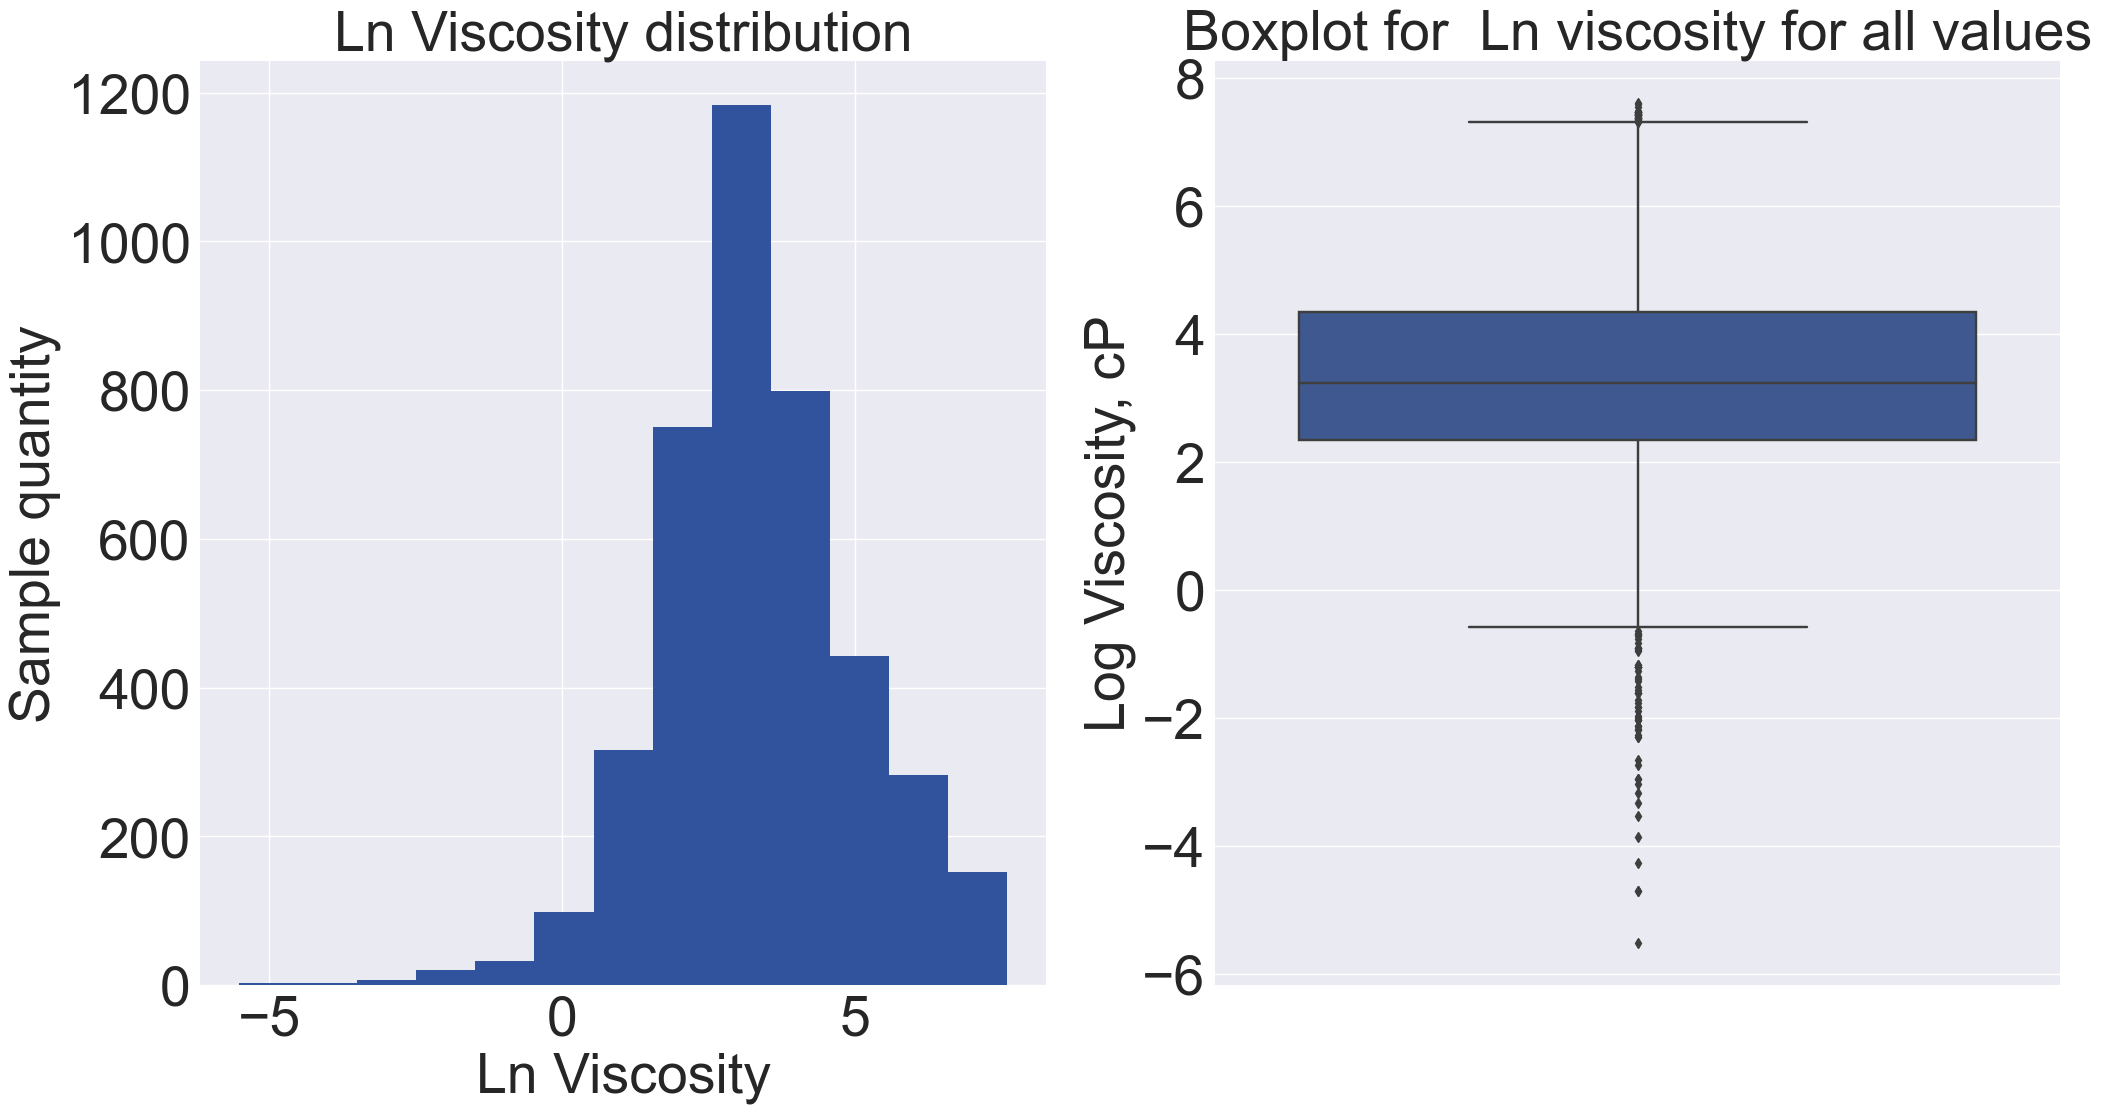

In [61]:
fig_time, ax_time = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax_time[0].hist(np.log(viscosity_df['Viscosity, cP']), color = colors[2], bins = 13) # Building a histogram
ax_time[0].set_title('Ln Viscosity distribution', fontsize=40) #Title
ax_time[0].set_xlabel('Ln Viscosity', fontsize=40) #X-axis signature
ax_time[0].set_ylabel('Sample quantity', fontsize=40) #Y-axis signature
ax_time[0].tick_params(axis='both', which='major', labelsize=40)
ax_time[1]= sns.boxplot(y = np.log(viscosity_df['Viscosity, cP']), color= colors[2]) #Building a boxplot
ax_time[1].set_title('Boxplot for  Ln viscosity for all values', fontsize=40) #Title
ax_time[1].set_ylabel('Log Viscosity, cP', fontsize=40) #Y-axis signature
ax_time[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() #Demonstration

###  4.2.2. Density distribution for two-component and three-component systems

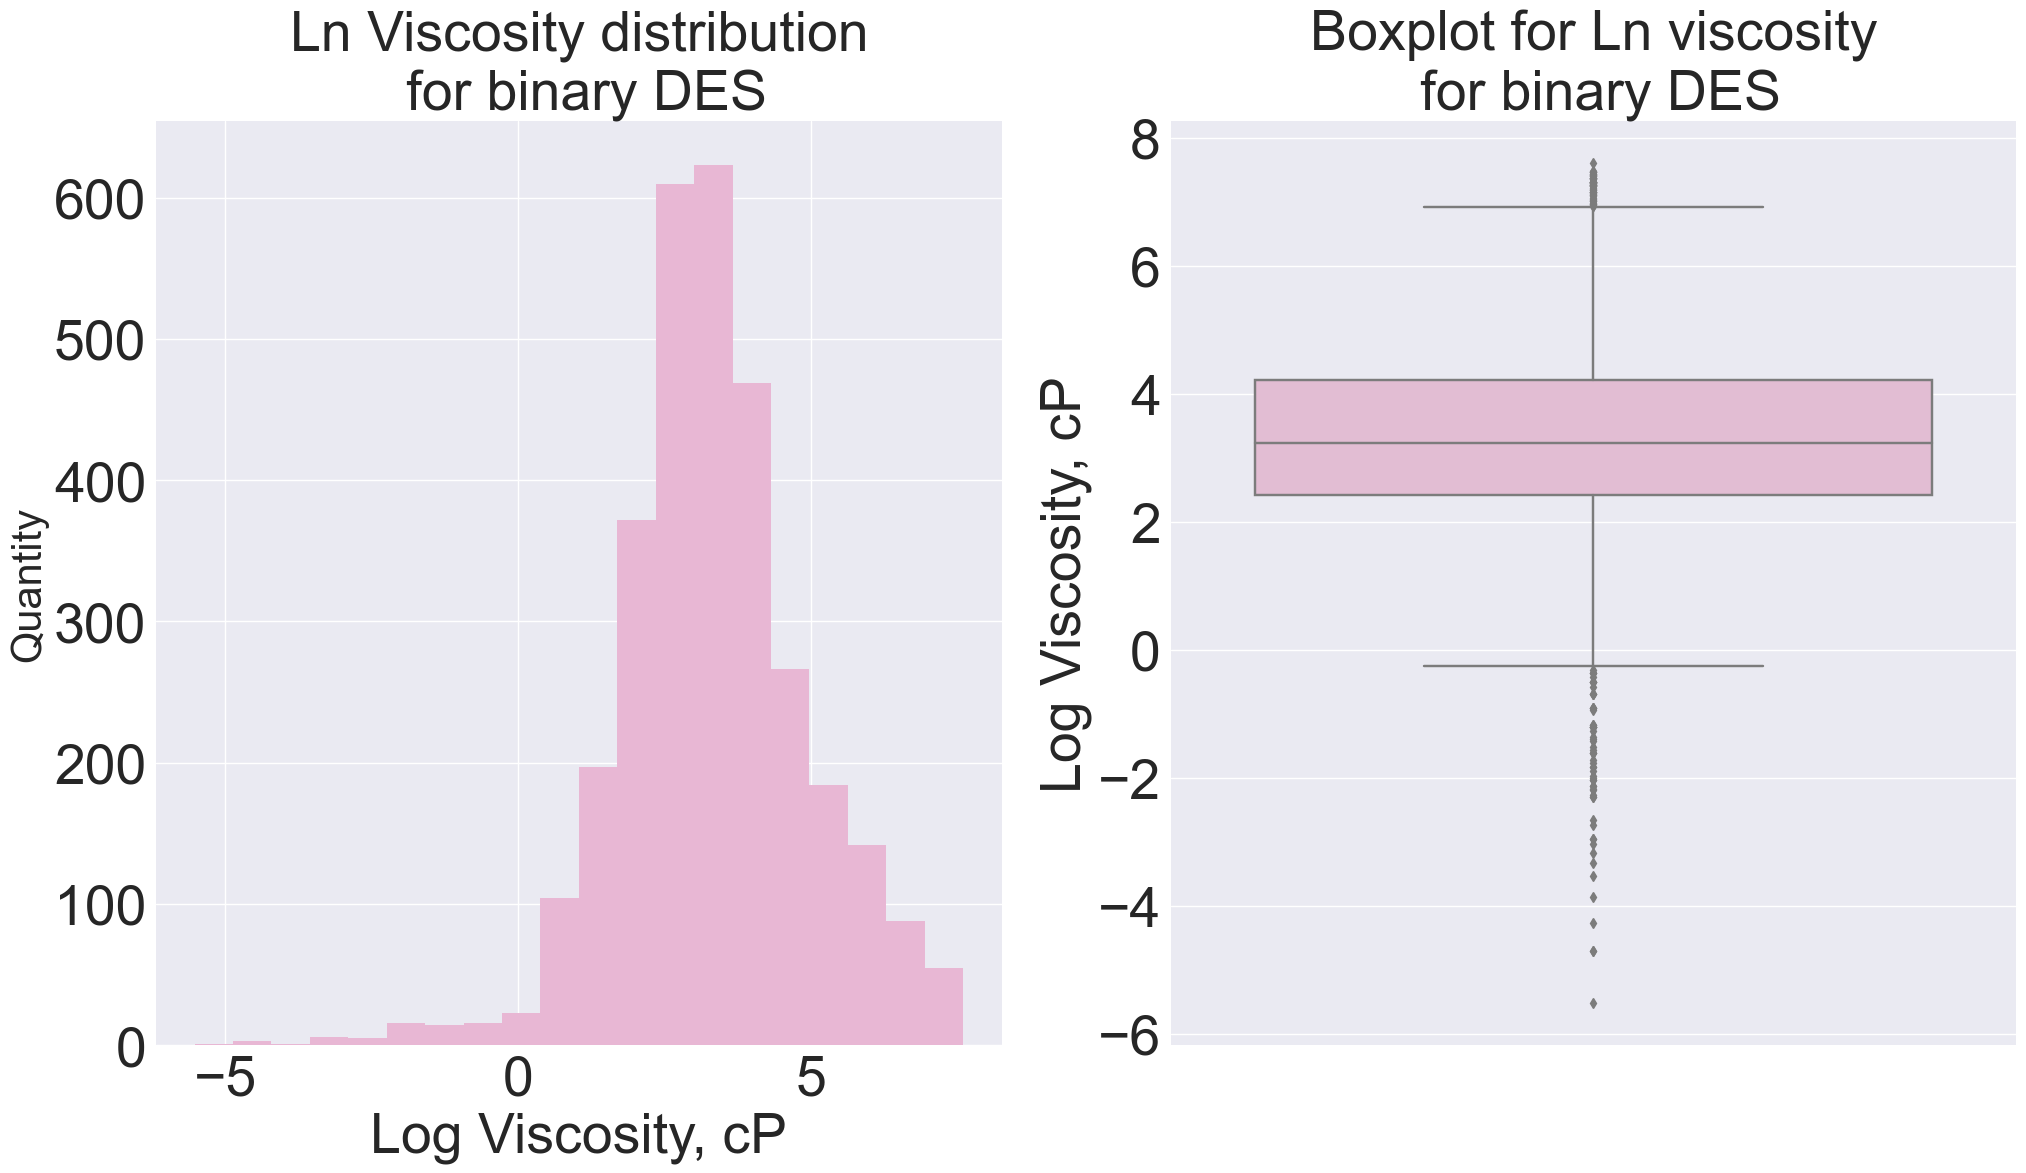

In [62]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax[0].hist(np.log(viscosity_df[viscosity_df['Number of components'] == 2]['Viscosity, cP']), color = colors[3], bins = 20) # Building a histogram
ax[0].set_title('Ln Viscosity distribution\n for binary DES', fontsize=40) #Title
ax[0].set_xlabel('Log Viscosity, cP', fontsize=40) #X-axis signature
ax[0].set_ylabel('Quantity', fontsize=30) #Y-axis signature
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[1] = sns.boxplot(y = np.log(viscosity_df[viscosity_df['Number of components'] == 2]['Viscosity, cP']), color = colors[3]) #Building a boxplot
ax[1].set_title('Boxplot for Ln viscosity\n for binary DES', fontsize=40) #Title
ax[1].set_ylabel('Log Viscosity, cP', fontsize=40) #Y-axis signature
ax[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() #Demonstration

There is a small tail in the negative area

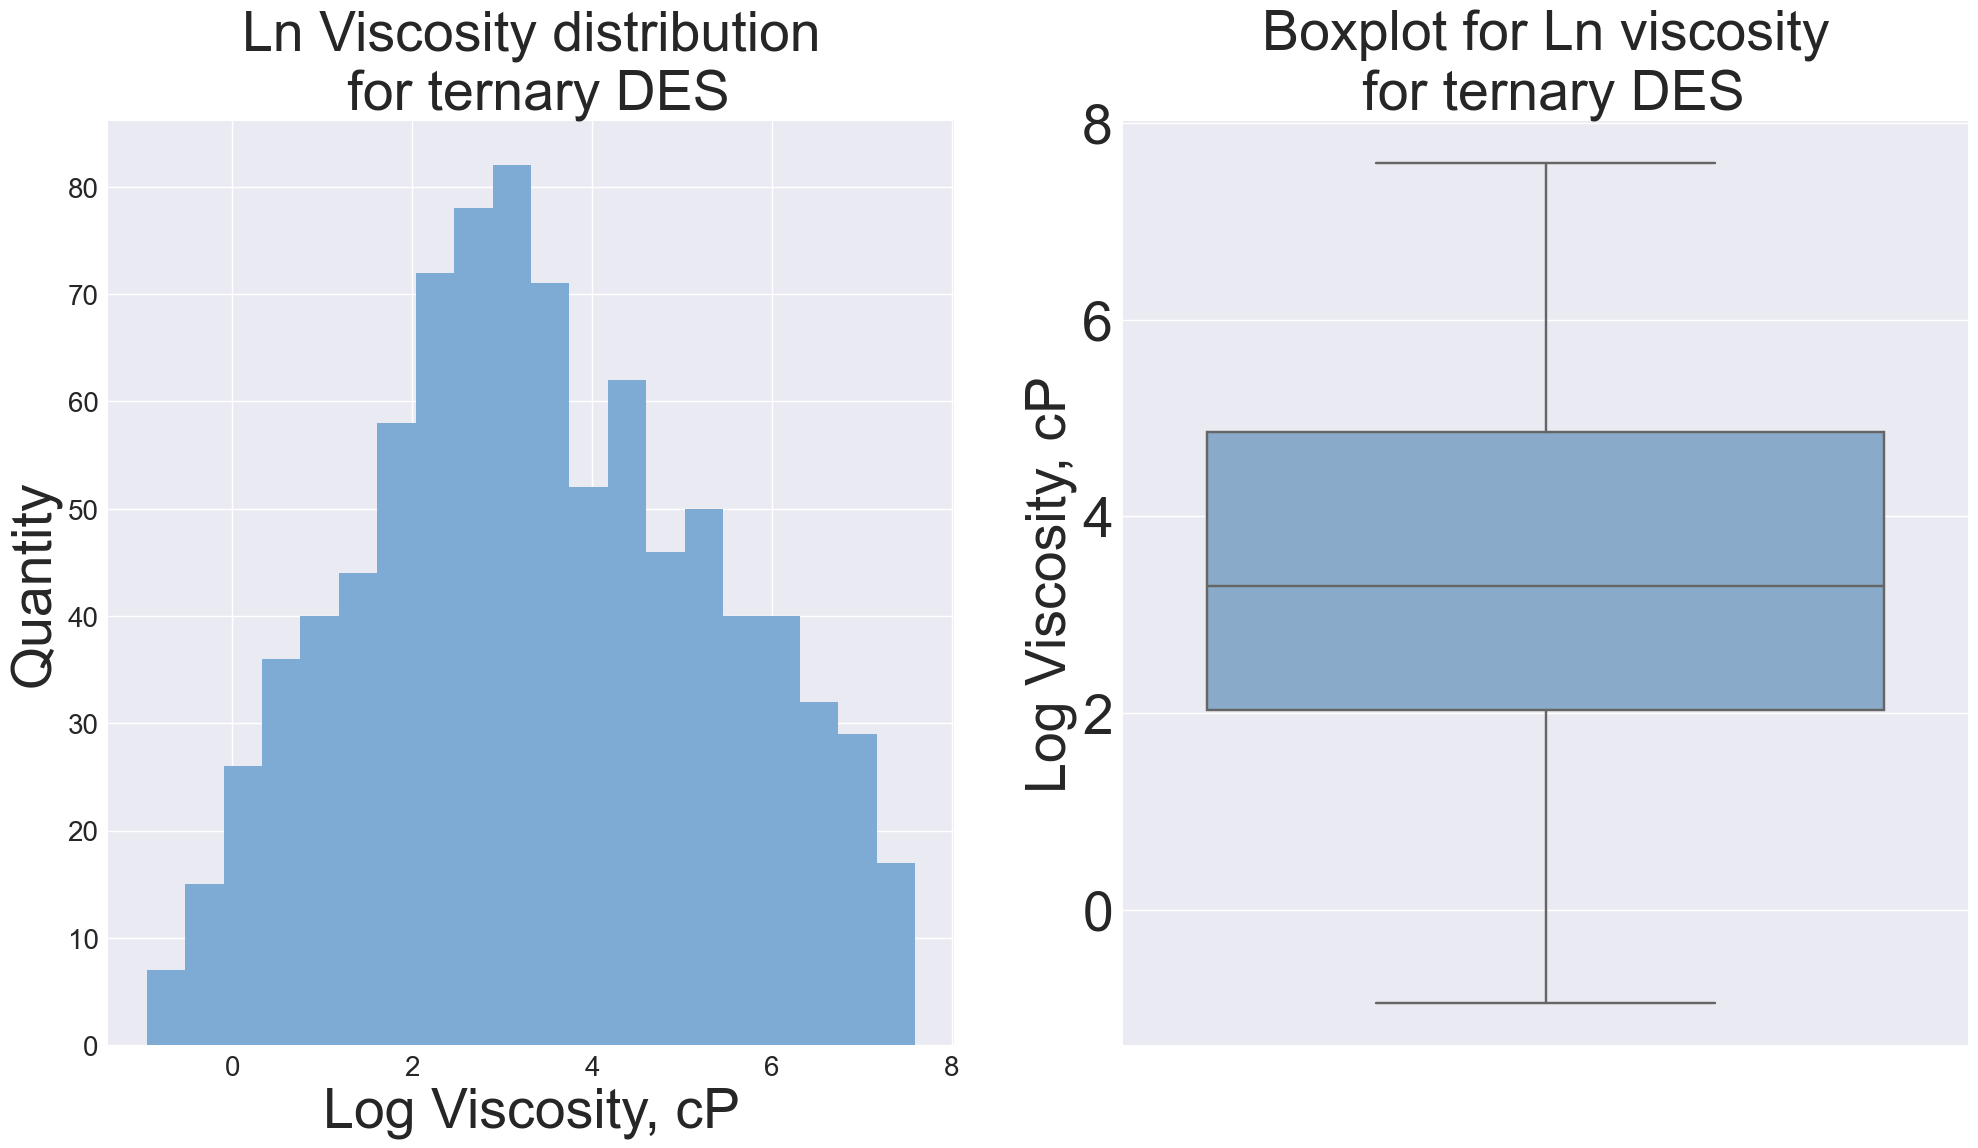

In [63]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax[0].hist(np.log(viscosity_df[viscosity_df['Number of components'] == 3]['Viscosity, cP']), color = colors[4], bins = 20) # Building a histogram
ax[0].set_title('Ln Viscosity distribution\n for ternary DES', fontsize=40) #Title
ax[0].set_xlabel('Log Viscosity, cP', fontsize=40) #X-axis signature
ax[0].set_ylabel('Quantity', fontsize=40) #Y-axis signature
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1] = sns.boxplot(y = np.log(viscosity_df[viscosity_df['Number of components'] == 3]['Viscosity, cP']), color = colors[4]) #Building a boxplot
ax[1].set_title('Boxplot for Ln viscosity\n for ternary DES', fontsize=40) #Title
ax[1].set_ylabel('Log Viscosity, cP', fontsize=40) #Y-axis signature
ax[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() #Demonstration

The distribution is close to normal and covers the entire positive range of values

### 4.2.3. Распределение плотности для различных типов бинарных систем

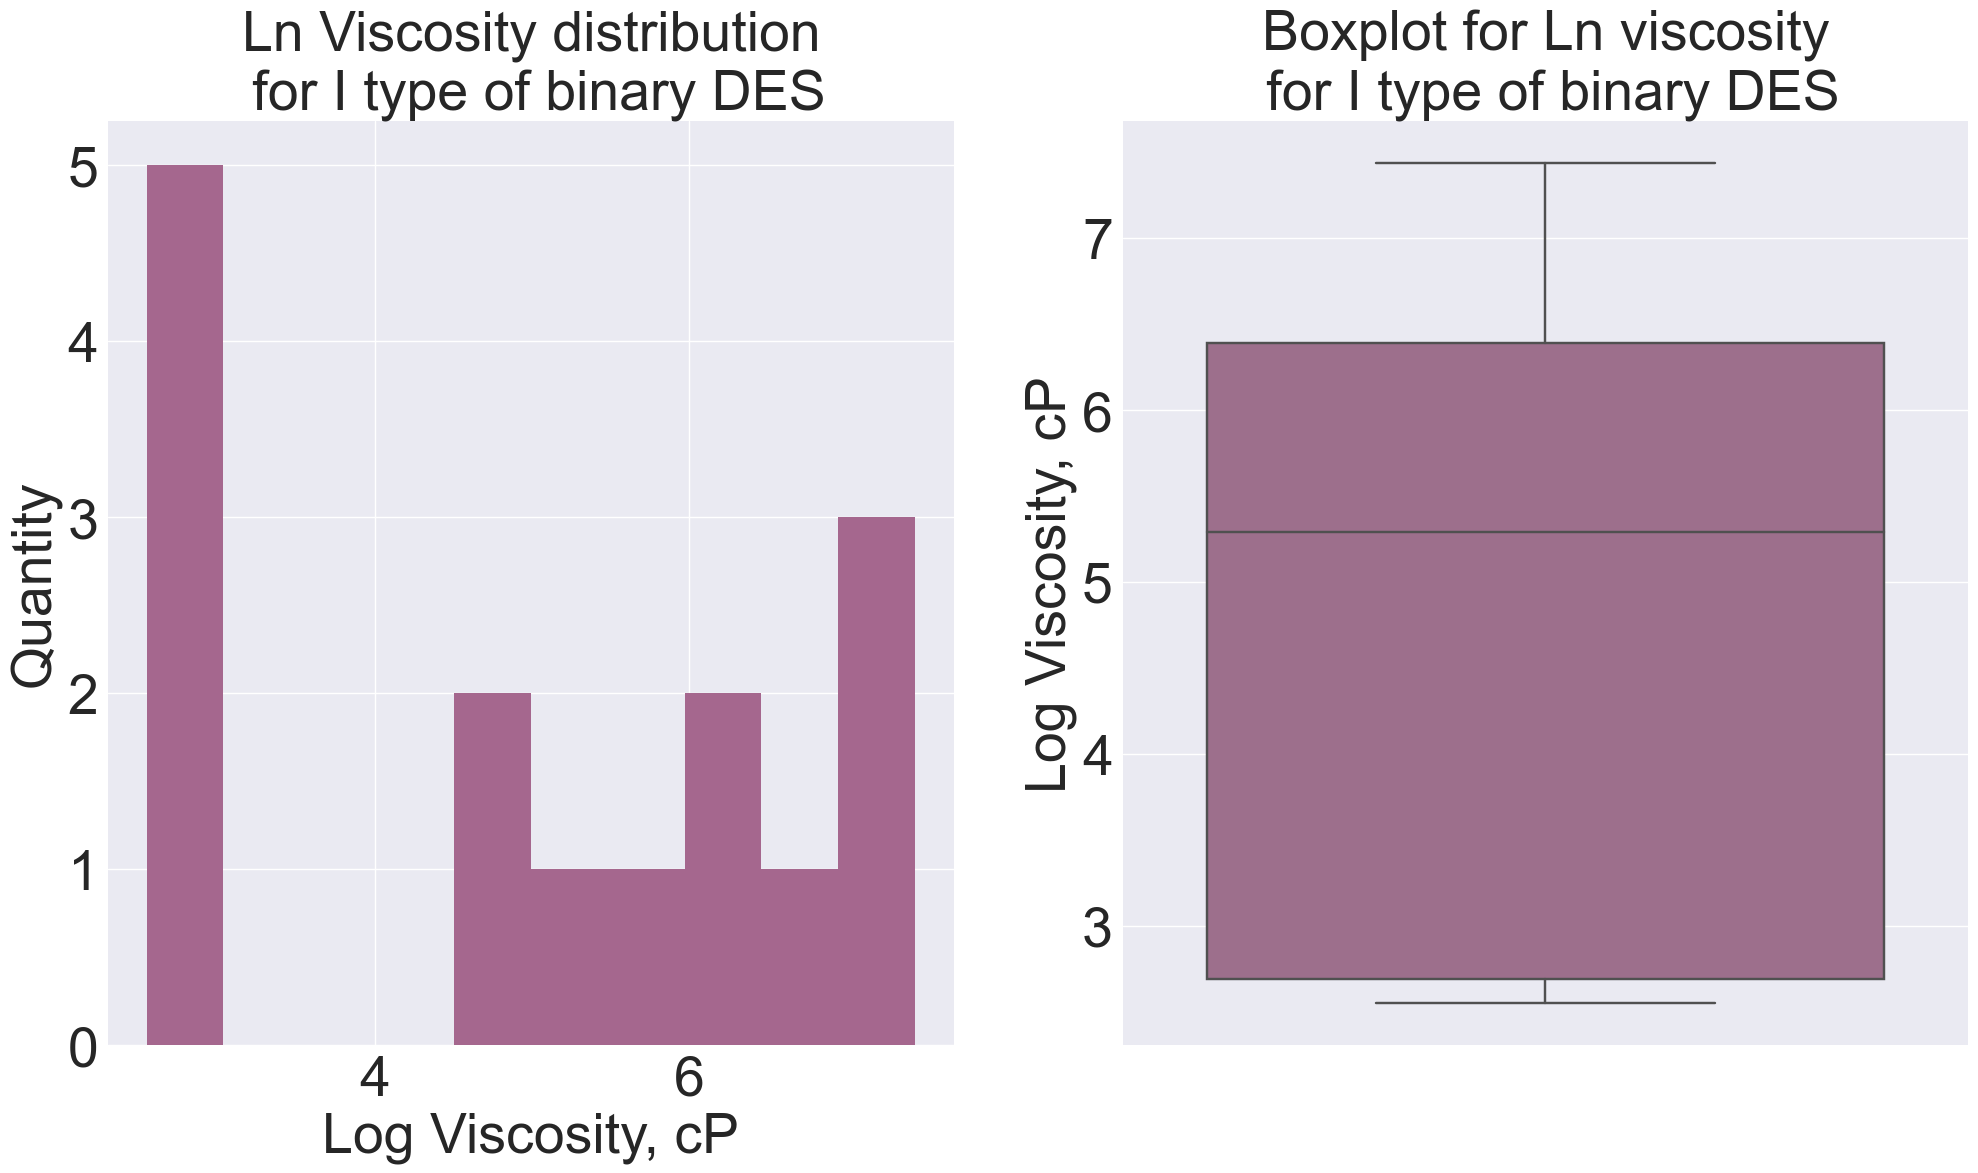

In [64]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax[0].hist(np.log(viscosity_df[viscosity_df['Type of DES'] == 'Ⅰ']['Viscosity, cP']), color = colors[0]) # Building a histogram
ax[0].set_title('Ln Viscosity distribution\n for I type of binary DES', fontsize=40) #Title
ax[0].set_xlabel('Log Viscosity, cP', fontsize=40) #X-axis signature
ax[0].set_ylabel('Quantity', fontsize=40) #Y-axis signature
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[1] = sns.boxplot(y = np.log(viscosity_df[viscosity_df['Type of DES'] == 'Ⅰ']['Viscosity, cP']), color = colors[0]) #Building a boxplot
ax[1].set_title('Boxplot for Ln viscosity\n for I type of binary DES', fontsize=40) #Title
ax[1].set_ylabel('Log Viscosity, cP', fontsize=40) #Y-axis signature
ax[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() #Demonstration

There is little DES type I data in the table, so the distribution is interrupted

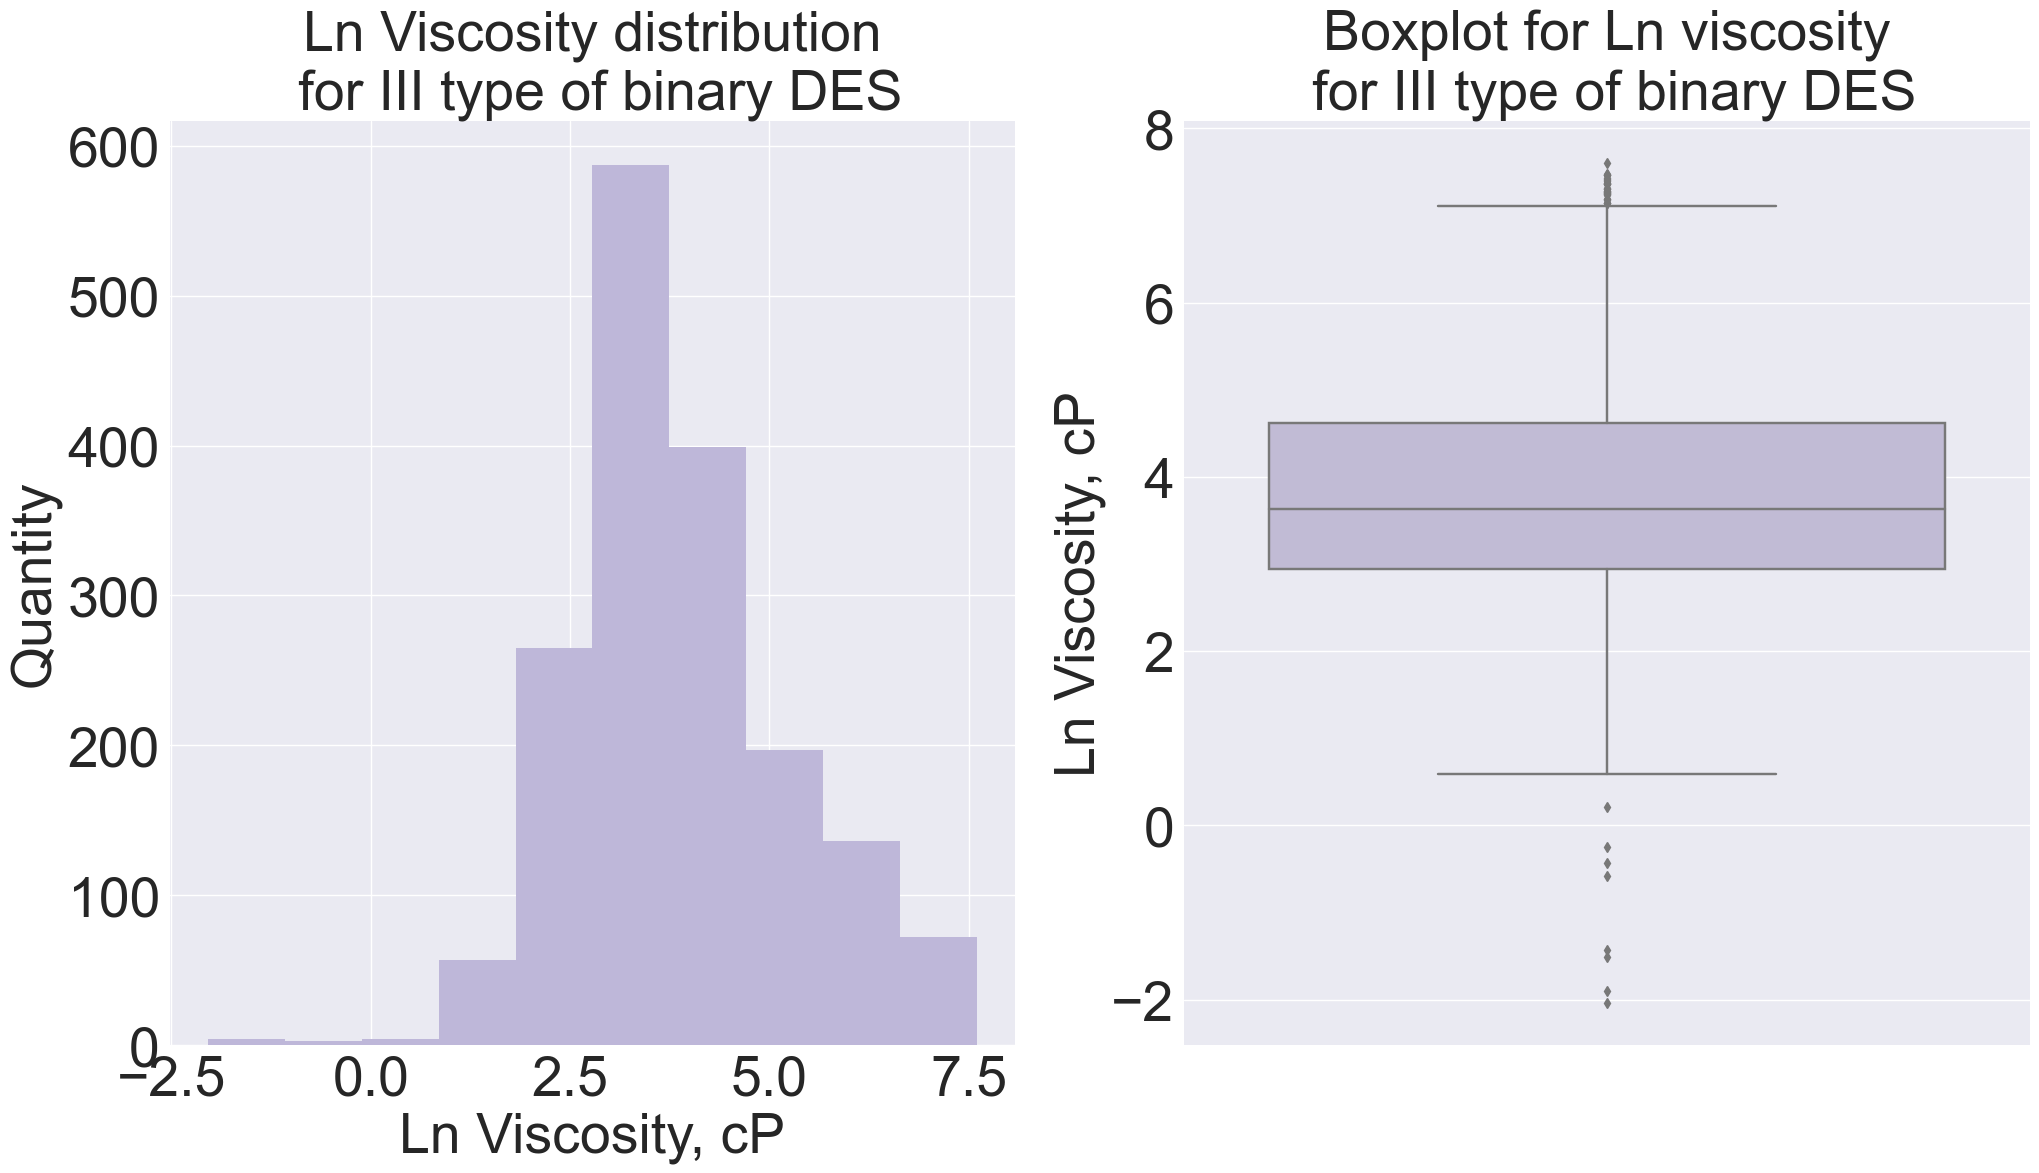

In [65]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax[0].hist(np.log(viscosity_df[viscosity_df['Type of DES'] == 'Ⅲ']['Viscosity, cP']), color = colors[1]) # Building a histogram
ax[0].set_title('Ln Viscosity distribution\n for III type of binary DES', fontsize=40) #Title
ax[0].set_xlabel('Ln Viscosity, cP', fontsize=40) #X-axis signature
ax[0].set_ylabel('Quantity', fontsize=40) #Y-axis signature
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[1] = sns.boxplot(y = np.log(viscosity_df[viscosity_df['Type of DES'] == 'Ⅲ']['Viscosity, cP']), color = colors[1]) #Building a boxplot
ax[1].set_title('Boxplot for Ln viscosity\n for III type of binary DES', fontsize=40) #Title
ax[1].set_ylabel('Ln Viscosity, cP', fontsize=40) #Y-axis signature
ax[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() #Demonstration

There are emissions in the area of -2.5 - 0.0

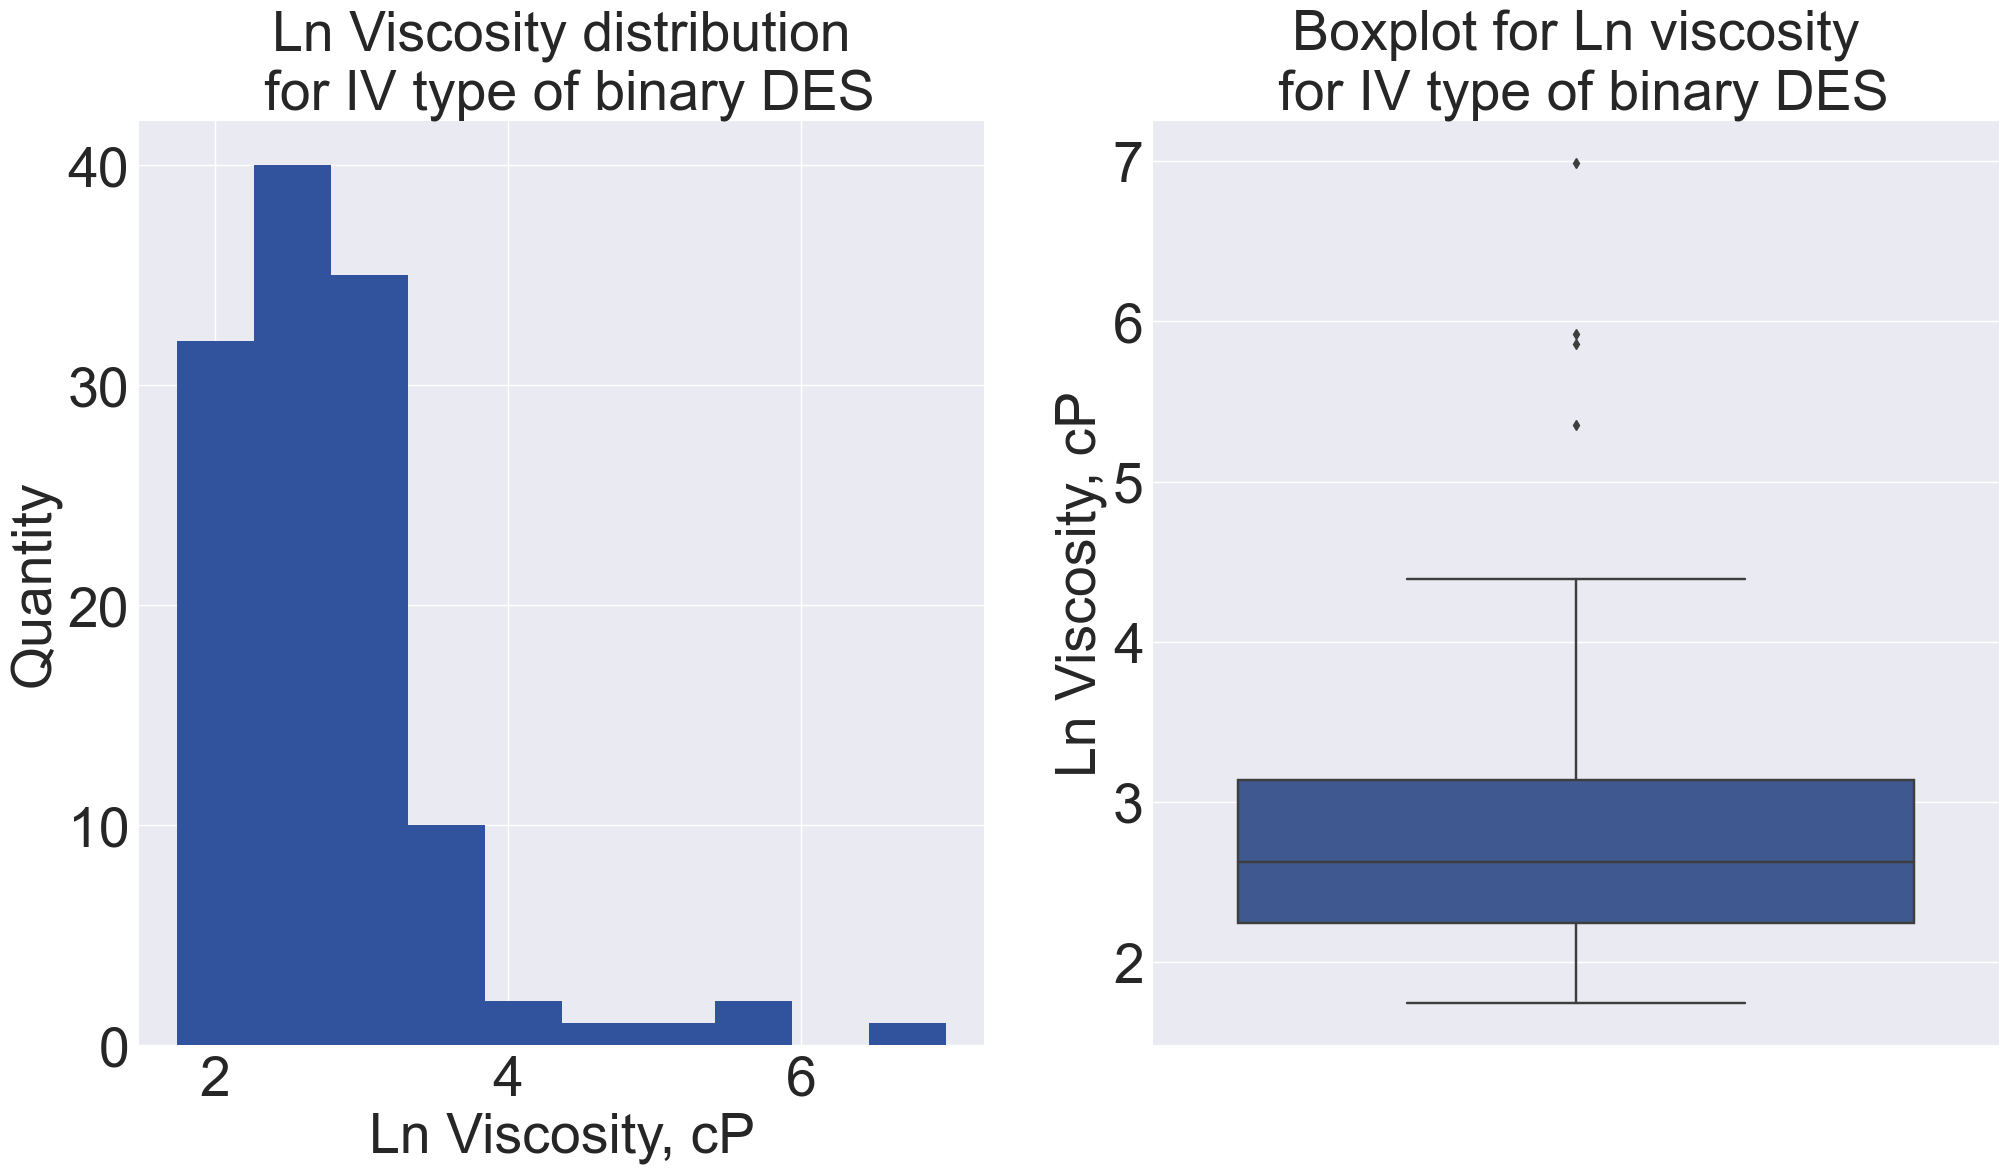

In [73]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax[0].hist(np.log(viscosity_df[viscosity_df['Type of DES'] == 'Ⅳ']['Viscosity, cP']), color = colors[2]) # Building a histogram
ax[0].set_title('Ln Viscosity distribution\n for IV type of binary DES', fontsize=40) #Title
ax[0].set_xlabel('Ln Viscosity, cP', fontsize=40) #X-axis signature
ax[0].set_ylabel('Quantity', fontsize=40) #Y-axis signature
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[1] = sns.boxplot(y = np.log(viscosity_df[viscosity_df['Type of DES'] == 'Ⅳ']['Viscosity, cP']), color = colors[2]) #Building a boxplot
ax[1].set_title('Boxplot for Ln viscosity\n for IV type of binary DES', fontsize=40) #Title
ax[1].set_ylabel('Ln Viscosity, cP', fontsize=40) #Y-axis signature
ax[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() #Demonstration

The main values are in the region 2-3.5, as well as emissions in the region 6

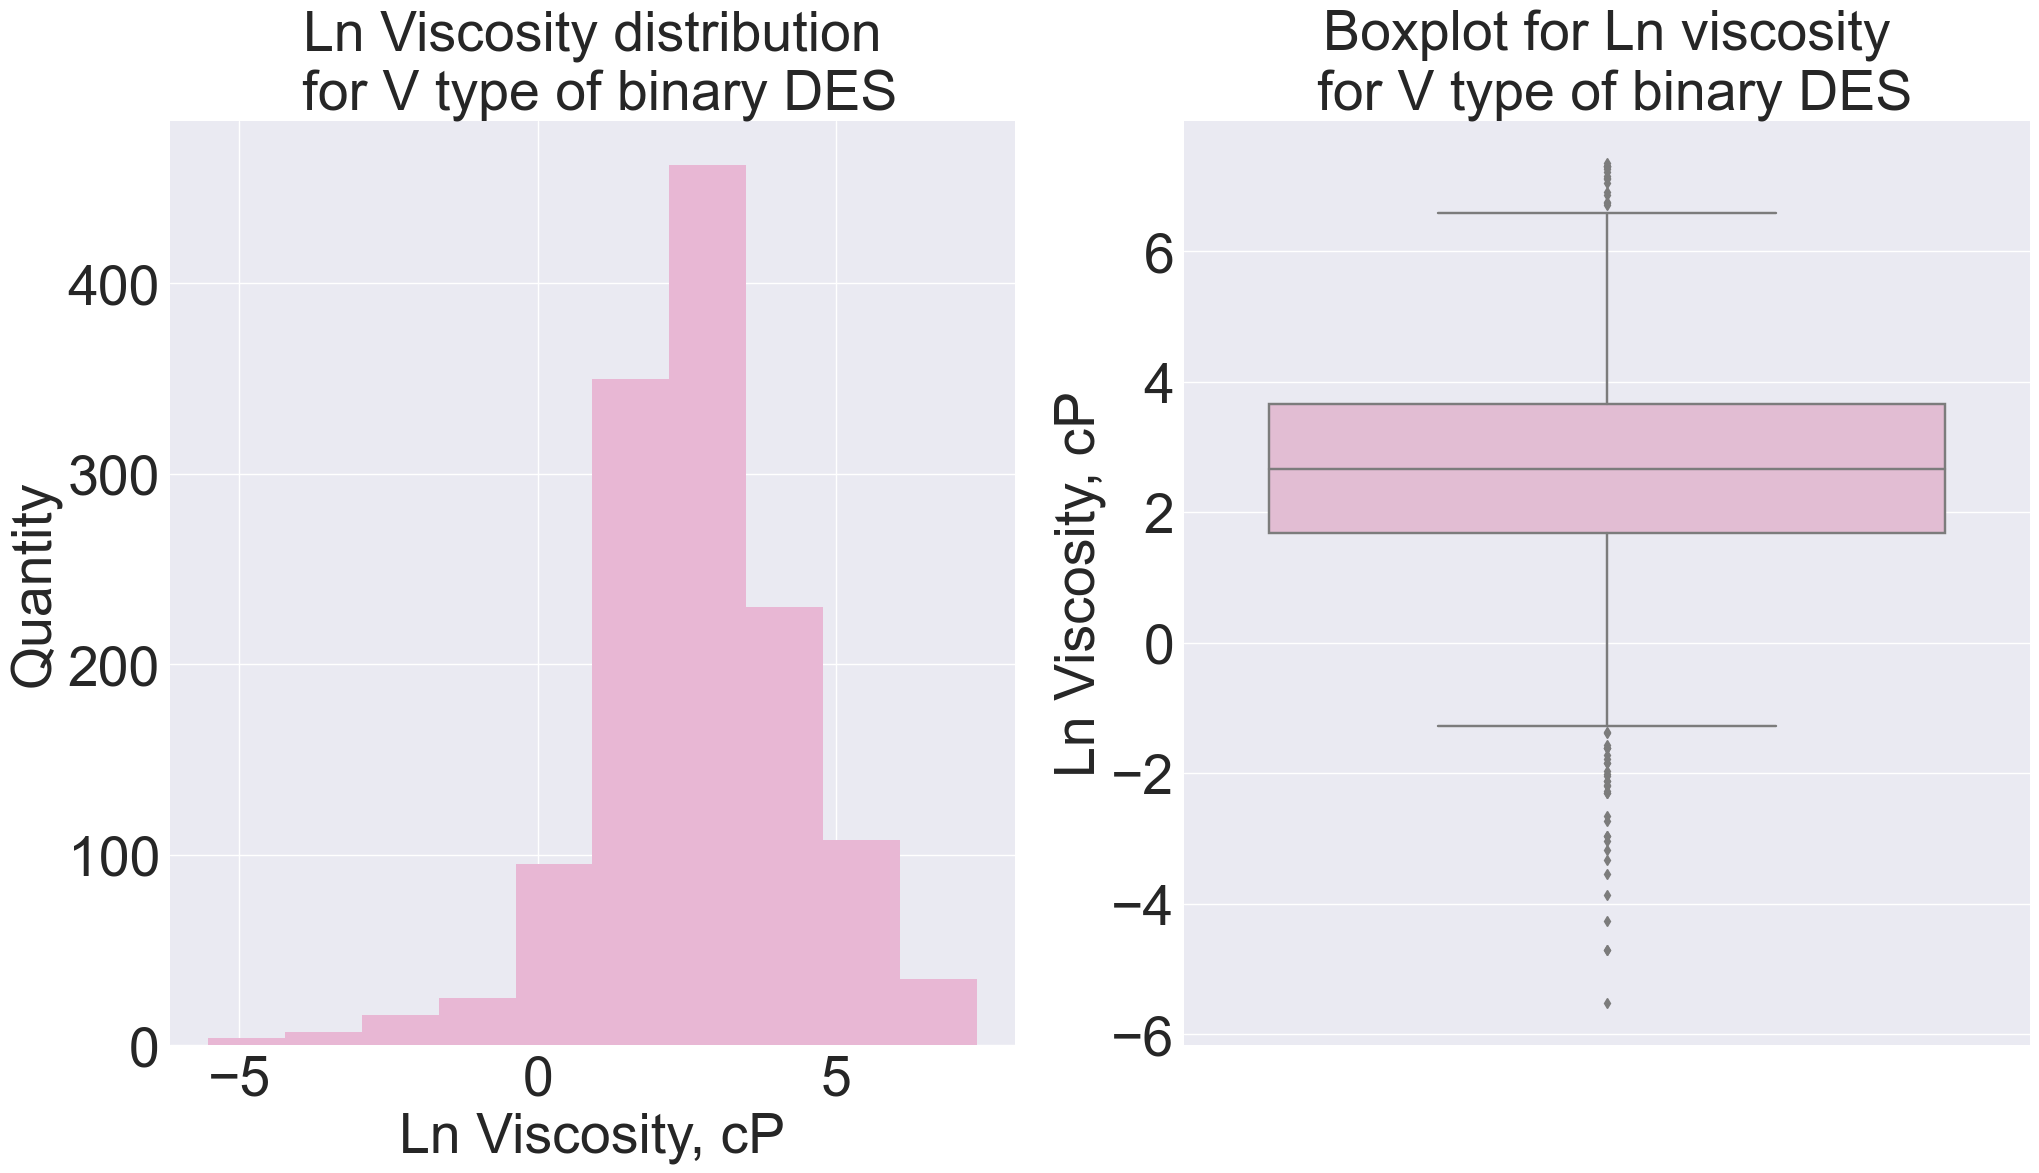

In [74]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax[0].hist(np.log(viscosity_df[viscosity_df['Type of DES'] == 'Ⅴ']['Viscosity, cP']), color = colors[3]) # Building a histogram
ax[0].set_title('Ln Viscosity distribution\n for V type of binary DES', fontsize=40) #Title
ax[0].set_xlabel('Ln Viscosity, cP', fontsize=40) #X-axis signature
ax[0].set_ylabel('Quantity', fontsize=40) #Y-axis signature
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[1] = sns.boxplot(y = np.log(viscosity_df[viscosity_df['Type of DES'] == 'Ⅴ']['Viscosity, cP']), color = colors[3]) #Building a boxplot
ax[1].set_title('Boxplot for Ln viscosity\n for V type of binary DES', fontsize=40) #Title
ax[1].set_ylabel('Ln Viscosity, cP', fontsize=40) #Y-axis signature
ax[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() #Demonstration

The distribution is close to normal, there are small outliers around -5 - 0

## 4.3. Violinplots for viscosity of different types DES

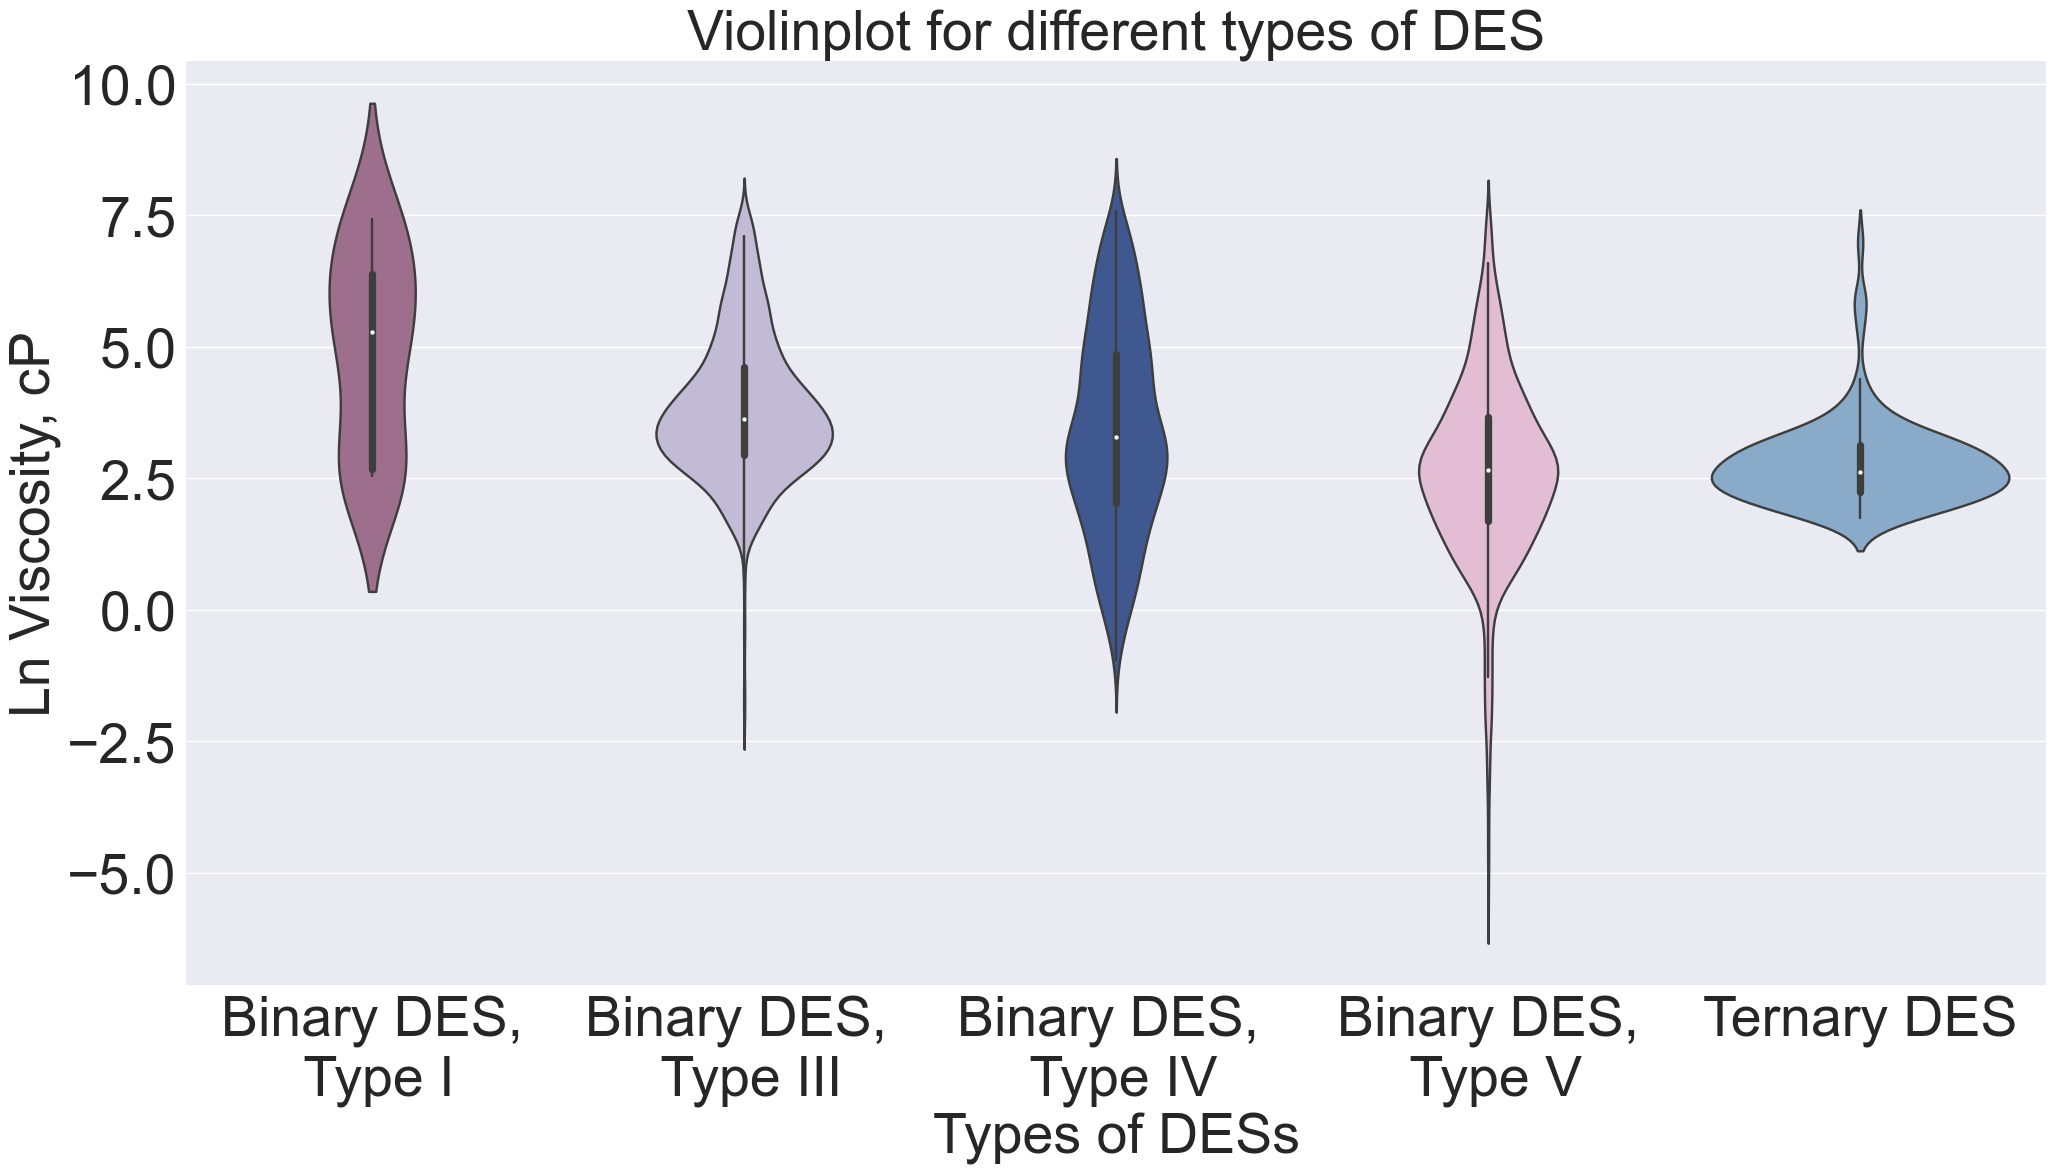

In [75]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (24, 12)) # Initialization
ax = sns.violinplot(y = np.log(viscosity_df['Viscosity, cP']), x = viscosity_df['Type of DES'], palette = colors) #Building a violinplot
ax.set_xticks([0, 1,2,3,4], labels= ['Binary DES,\n Type I', 'Binary DES, \n Type III', 'Binary DES, \n Type IV', 'Binary DES,\n Type V', 'Ternary DES'])
ax.set_title('Violinplot for different types of DES', fontsize=40) #Title
ax.set_ylabel('Ln Viscosity, cP', fontsize=40) #Y-axis signature
ax.set_xlabel('Types of DESs', fontsize=40) #X-axis signature
ax.tick_params(axis='both', which='major', labelsize=40)
plt.show() #Demonstration

It can be seen that all types have the same average value of the logarithm of viscosity about 2.5, type I is distinguished, which, due to the presence of metallic salts, is characterized by a high viscosity value

## 4.4. Distribution of temperature values
Let's build a histogram to see the temperature range in which our model will be able to make predictions

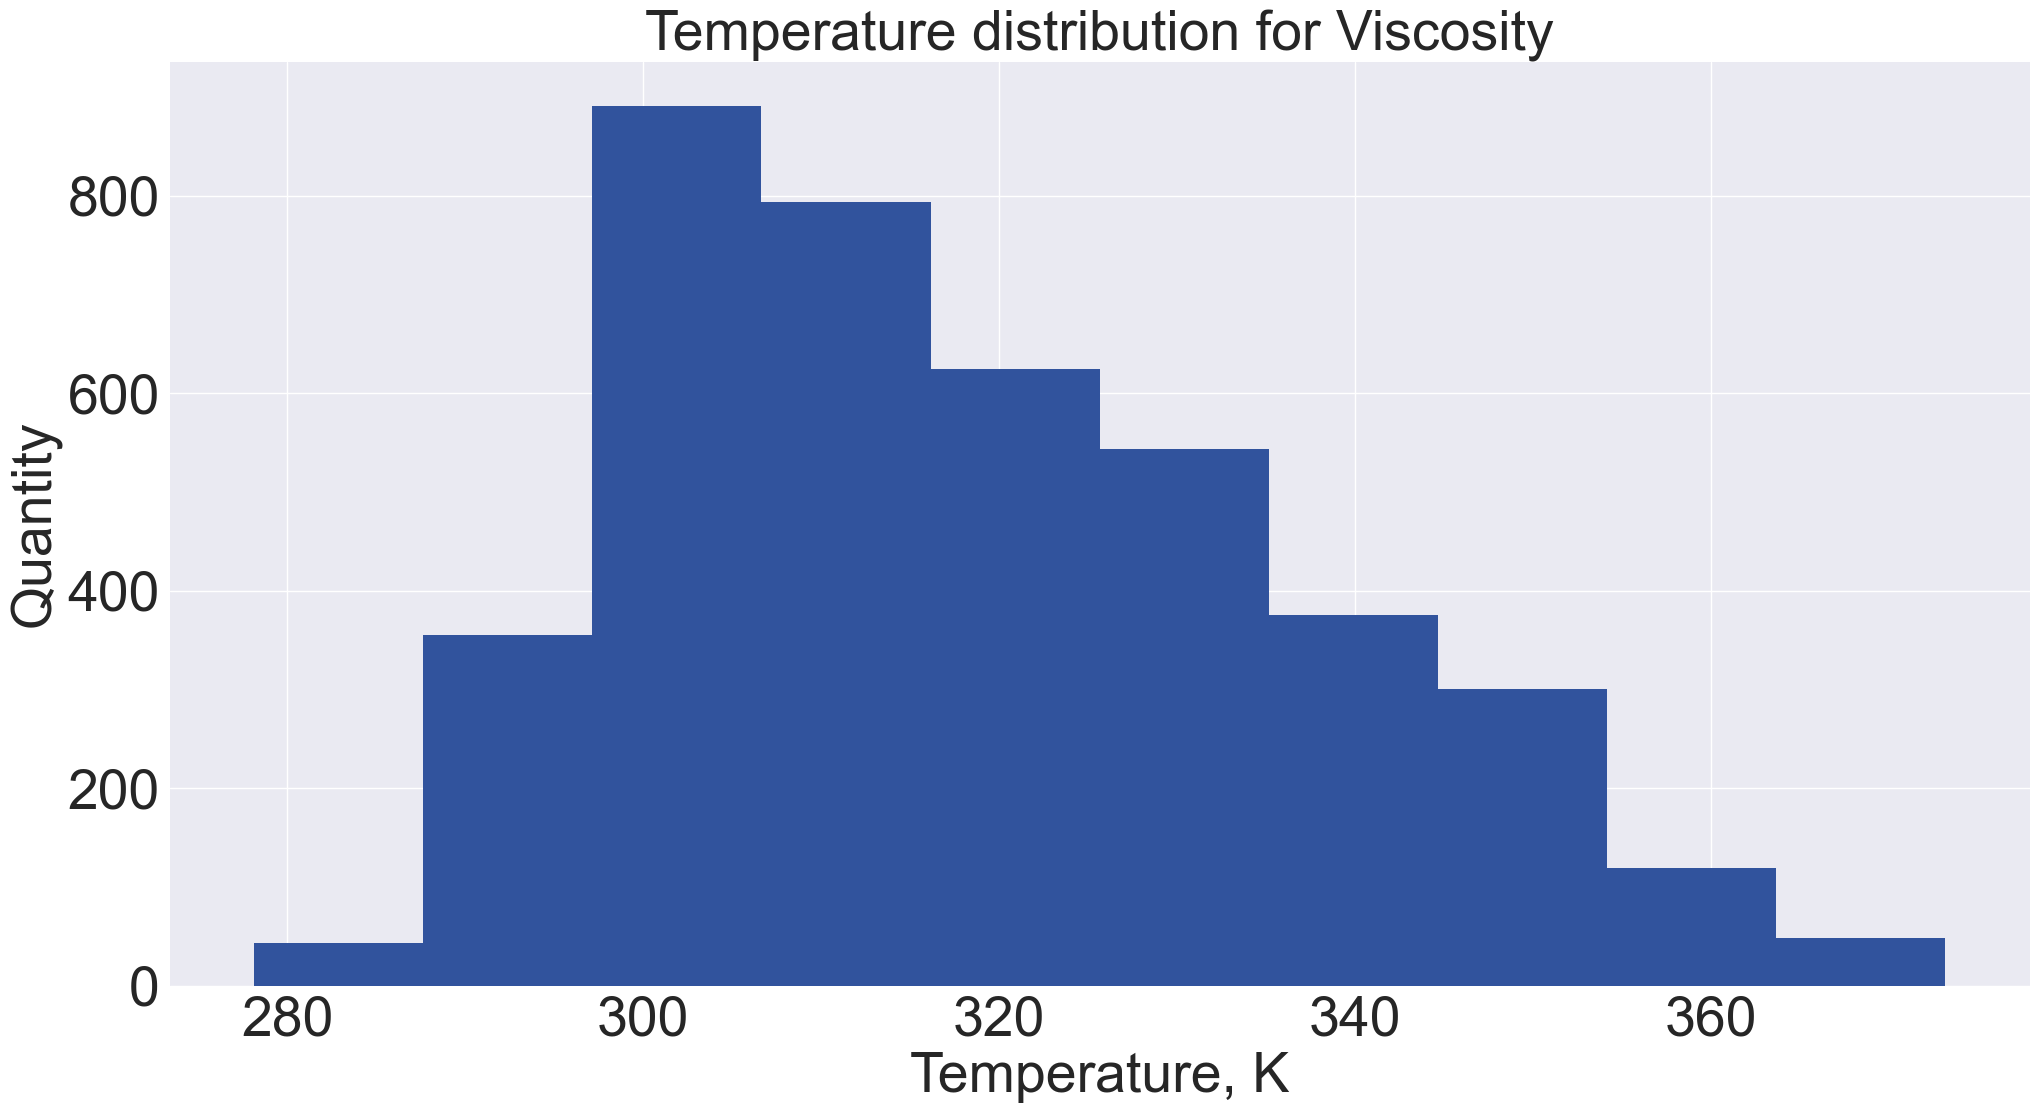

In [76]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (24, 12)) # Initialization
ax.hist(viscosity_df['Temperature, K'], color = colors[2], bins = 10) # Building a histogram
ax.set_title('Temperature distribution for Viscosity', fontsize=40) #Title
ax.set_xlabel('Temperature, K', fontsize=40) #X-axis signature
ax.set_ylabel('Quantity', fontsize=40) #Y-axis signature
ax.tick_params(axis='both', which='major', labelsize=40)

In [77]:
print(viscosity_df['Temperature, K'].min())
print(viscosity_df['Temperature, K'].max())

278.15
373.15


## 4.5. Statistical tests
### 4.5.1. Shapiro-Wilk

In [78]:
from scipy.stats import shapiro
data = viscosity_df['Viscosity, cP']
stat, p = shapiro(data)
print
print(stat, p)
print('stat={0:.3f}, p={0:.3f}' .format(stat, p))
if p > 0.05:
    print(p)
    print('Probably Gaussian')
else:
    print(p)
    print('Probably not Gaussian')

0.4591681957244873 0.0
stat=0.459, p=0.459
0.0
Probably not Gaussian


### 4.5.2. Jarque-Bera test

In [79]:
from scipy.stats import jarque_bera
print(jarque_bera(data))

SignificanceResult(statistic=67870.51018776046, pvalue=0.0)


Both tests have a low p-value and a high stat value, so the null hypothesis is rejected, our distribution is not normal